### <center>**Проект: *Агентство Недвижимости***</center>

<center>
<img src="https://blogsmedia.lse.ac.uk/blogs.dir/120/files/2020/11/Untitled-design-1.png" alt="Логотип Markdown" width="720" height="480"></center>

### <center> **1. Problem Definition - Определение задачи** </center>

#### **Задача проекта:** *Разработать сервис для предсказания стоимости домов на основе истории предложений*
#### **Описание проекта:** 
##### **К нам обратился представитель крупного агентства недвижимости со следующей проблемой:**
*"Мои риелторы тратят катастрофически много времени на сортировку
объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да
и, сказать по правде, качество анализа не дотягивают до уровня конкурентов.
Это сказывается на наших финансовых показателях."*



##### **Наша задача — разработать модель, которая позволила бы обойти конкурентов по скорости и качеству совершения сделок.**


#### **Перед нами задача классической регрессии, предсказывать будем стоимость недвижимости. В качестве метрик качества будем использовать `MAE` и `RMSE`**


In [ ]:
# все импорты в этой ячейке
import re
import json
from functools import partial
import pickle

import pandas as pd
import numpy as np

from scipy.stats import shapiro, norm
from scipy.stats import mannwhitneyu, kruskal
from statsmodels.graphics.gofplots import qqplot

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import Pool, CatBoostRegressor, cv

import xgboost as xgb

import optuna

from warnings import filterwarnings

for category in (FutureWarning, UserWarning):
    filterwarnings(action='ignore', category=category)

### <center> **2. Data Preprocessing - Предобработка данных и первичное исследование** </center>

In [403]:
df = pd.read_csv('data/data.csv')

In [404]:
df.shape

(377185, 18)

In [405]:
df.head() # посмотрим как структурно выглядит dataset

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [406]:
df.describe() # выведем основные статистики

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


In [407]:
# просто ВАУ, обрабатывать придется практически все перед анализом данных, 
# так все признаки в моделях регрессии нам необходимо будет привести в цифровой вид

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [408]:
df.duplicated(keep='first').sum() # проверим есть ли дубликаты

50

In [409]:
df.drop_duplicates(inplace=True) # удаляем все дубликаты в данных

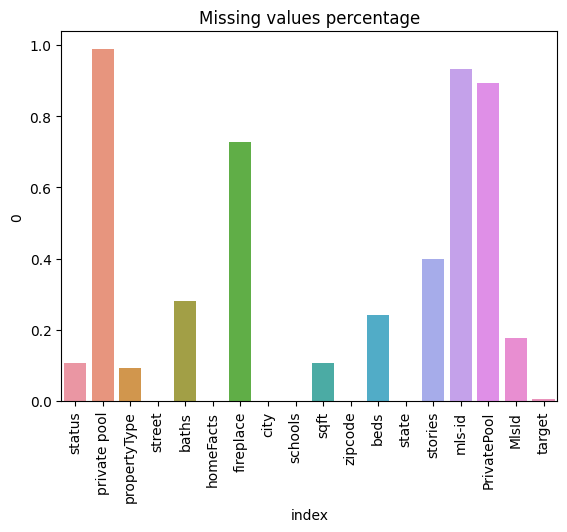

In [410]:
# преверяем на пропуски и визуализируем результат
# выглядит ужасно, ощущение, что придется снести половину признаков здесь и сейчас,
# однако иногда всё не то чем кажется, точнее кажется не только лишь всё...(c) Классик :)

def nan_visual(df):
    data_len = df.shape[0]
    data_to_visual = (df.isna().sum() / data_len).reset_index()
    sns.barplot(data_to_visual, x='index', y=0)
    plt.xticks(rotation=90)
    plt.title('Missing values percentage')
    return plt.show()
    
nan_visual(df)

Предварительно, по результатам визуализации видим 4 признака которые имею пропуски более 70%, от которых поидеи нужно избавиться, однако стоит перед тем как это делать присмотреться к каждому из них по детальнее. Что касаемо остальных признаков, то их нужно будет детально посмотреть и выбрать стратегию заполнения пропусков.

In [411]:
# по всей видимости это идентификаторы, поэтому удаляем их, так как в дальнейшем они нам не пригодятся ни в пайплайне ни в модели
df.drop(['mls-id', 'MlsId'], axis=1, inplace=True)

In [412]:
# также удалим пропуски в целевом признаке, нам они не понадобятся
df.dropna(subset=['target'], inplace=True) 

In [413]:
# посмотрим детальнее на признак target какие строковые значения там могут содержаться
# и видим, что в помимо домов которые учитывают стоимость дома, у нас есть арендные предложения,
# которые на тут не нужны

display(df[df['target'].str.contains('[a-zA-Z]', na=False)][:5])
print('Количество наблюдений со статусом аренда ->', df[df['target'].str.contains('[a-zA-Z]', na=False)].shape[0])

# избавляемся от таких наблюдений
df = df[~df['target'].str.contains('[a-zA-Z]', na=False)]

# целевой признак не в цифровом виде, это нужно поправить, как говорится - на берегу!
df['target'] = df['target'].apply(lambda x: int(''.join(re.findall('\d', x))))

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
547,for rent,NaN,single-family home,4323 N Central Park Ave,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",yes,Chicago,"[{'rating': ['1/10', '4/10', '2/10', 'None/10'...","3,300 sqft",60618,4 Beds,IL,NaN,NaN,"$5,500/mo"
609,for rent,NaN,multi-family,220 Boylston St #1412,2 Baths,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",yes,Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,673 sqft",2116,2 Beds,MA,NaN,NaN,"$10,500/mo"
2075,for rent,NaN,single-family home,2830 NE 56th Ct,4 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...","2,400 sqft",33308,4 Beds,FL,NaN,yes,"$6,390/mo"
3025,for rent,NaN,multi-family,411 Kline Aly,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",NaN,Clarksville,"[{'rating': ['8/10', '9/10', '7/10'], 'data': ...","1,280 sqft",37040,2 Beds,TN,NaN,NaN,"$1,200/mo"
3645,for rent,NaN,multi-family,240 E Illinois St #2011,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",NaN,Chicago,"[{'rating': ['4/10', '7/10'], 'data': {'Distan...","1,473 sqft",60611,2 Beds,IL,NaN,yes,"$3,600/mo"


Количество наблюдений со статусом аренда -> 398


In [414]:
# посмотрим базовые статистики по целевому признаку, уже здесь видно, что вопервых имеются дома со стоимостью 1$
# 75 квантиль заканчивается на отметке примерно 600к$, а максимальный около 200 млн $ что в целом может быть, т.к. дома бывают такие где
# нибудь в районе Беверли Хиллз

df['target'].describe()

count    3.742570e+05
mean     6.454094e+05
std      1.842246e+06
min      1.000000e+00
25%      1.879000e+05
50%      3.200000e+05
75%      5.845000e+05
max      1.950000e+08
Name: target, dtype: float64

In [415]:
# Максимальное значение, слишком оличается от 75 квантиля, смотрим
# Ну да, это дом в районе Бель-Эйр значит с точки зрения максимального значения выбросов у нас нет
df[df['target']==df['target'].max()]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
132425,For sale,NaN,Single Family,875 Nimes Rd,18.0,"{'atAGlanceFacts': [{'factValue': '1935', 'fac...",Yes,Los Angeles,"[{'rating': ['10/10', '7/10'], 'data': {'Dista...",--,90077,11,CA,2,Yes,195000000


In [416]:
# По минимальным оценкам Google Дом в США, стоит в районе 10_000$ посмотрим сколько домов в дата-сете ниже этой стоимости

print("Количество домов которые дешевле 10_000$ ->", df[df['target']<10_000].shape[0])

# избавимся от таких наблюдений

df = df[df['target']>=10_000]

Количество домов которые дешевле 10_000$ -> 5647


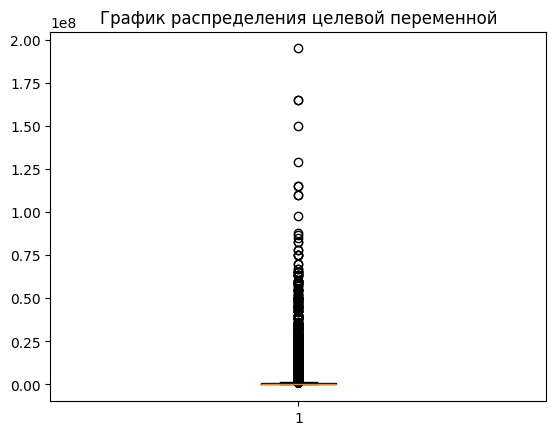

In [417]:
# взгляннем на данные визуально выглядит очень непонятно, 
# очевидно что данные распределены не нормально

plt.boxplot(df.target)
plt.title('График распределения целевой переменной')
plt.show()



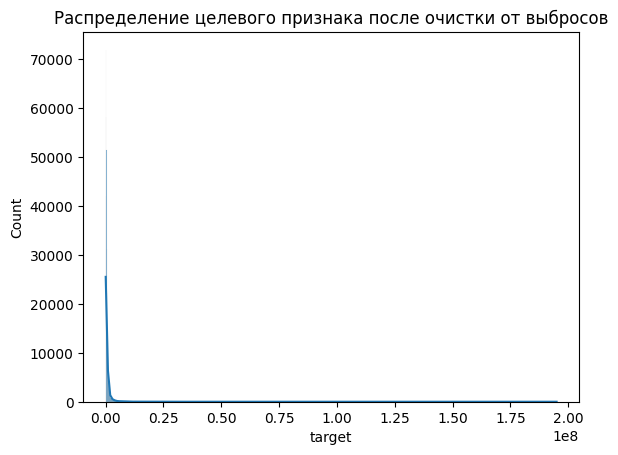

In [418]:
# построим гистограмму, для целевого признака и добавим оценку плотности
# у нас получилось что-то очень опять же ненормальное, видно что правый хвост данных очень сильно отличается
# оно и не удивительно, ведь у нас есть дома едва дороже 10k$ и дома за 200 млн $ в Бель-Эйр
# Поэтому имеет смысл прологарифмировать данные чтобы сгладить левый хвост

sns.histplot(df, x='target', kde=True, bins=2000)
plt.title('Распределение целевого признака после очистки от выбросов')
plt.show()

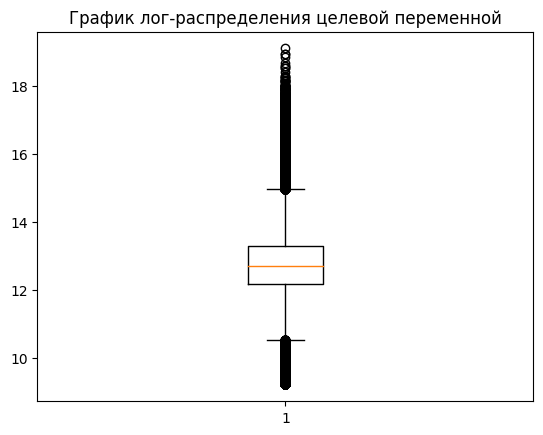

In [419]:
# попробуем прологорифмировать и посмотреть будет ли результат
plt.boxplot(np.log(df.target)) # таргетные данные строго больше или равно 1 поэтому разумно использовать натуральный логарифм
plt.title('График лог-распределения целевой переменной')
plt.show()

Text(0.5, 1.0, 'Распределение целевой переменной после логарифмирования')

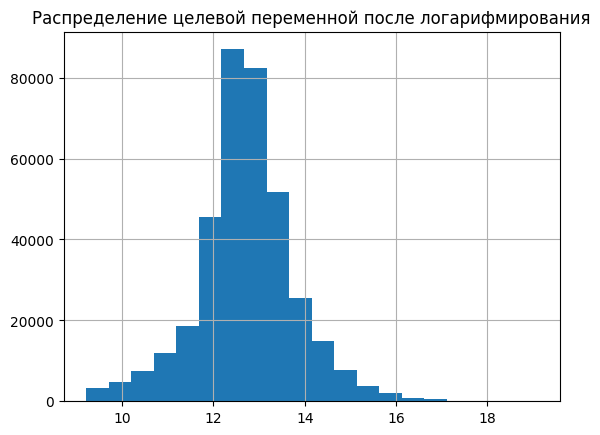

In [420]:
# Если прологарифмировать целевой признак то выглядит очень похожим на нормальное распределение, нужно проверить это стат.тестом

df['target'].apply(lambda x: np.log(x)).hist(bins=20)
plt.title('Распределение целевой переменной после логарифмирования')

In [421]:
# Несмотря на то, что распределение целевого признака выглядит нормально, данные не распределены нормально,
# согласно тесту Шапиро-Уилка
# Однако визуально выглядит такое распределение гораздо лучше при построении модели учтем этот фактор

_, p_value = shapiro(df['target'].apply(lambda x: np.log(x)))

alpha = .05

if p_value > alpha:
    print("Данные распределены нормально {}".format(p_value))
else: 
    print("Данные не распределены нормально {}".format(p_value))

Данные не распределены нормально 0.0


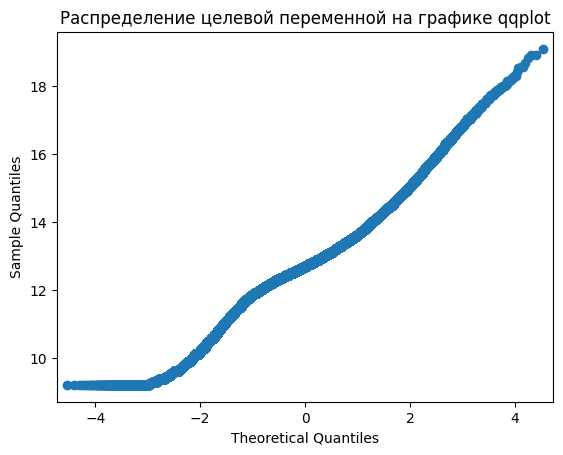

In [422]:
# На графике видно, что целевая переменная на распределена должным образом, из-за сильного левого хвоста, несмотря
# на логарифмирование, доминирование домов с низкой стоимостью не позволяет преобразовать целевую переменную
# к нормальному распределению с помощью данной техники
# Однако при построении модели можно попробовать логарифмированный вариант целевой переменной и сравнить метрики

qqplot(df['target'].apply(lambda x: np.log(x)), dist=norm)
plt.title("Распределение целевой переменной на графике qqplot")
plt.show()

In [423]:
# посмотрим на признак propertyType детальнее, видим что перед нами огромное количество разной недвижимости,
# Но в целом есть некая общность, мы видим что в первой 20ке сосредоточено более 90% всех размеченных домов,
# создадим функцию которая объеденит типы собственности, а для остальных присвоем категорию others

def property_type_cleaner(val):
    
    family_home_patern = re.compile(r'(?=.*single)(?=.*family)(?!.*Residence)(?=.*home)?', flags=re.IGNORECASE)
    condo_patern =  re.compile(r'condo', flags=re.IGNORECASE)
    multi_family_patern = re.compile(r'(?=.*multi)(?=.*family)', flags=re.IGNORECASE)
    land_patern = re.compile('(lot/land)|land', flags=re.IGNORECASE)
    
    if pd.isna(val):
        return np.nan
    if family_home_patern.findall(str(val)):
        return 'Single Family Home'
    if condo_patern.findall(str(val)):
        return 'Condominium'
    if land_patern.findall(str(val)):
        return 'land'
    if 'townhouse' in str(val).lower():
        return 'Townhouse'
    if multi_family_patern.findall(str(val)):
        return 'Multi Family Home'
    if 'traditional' in str(val).lower():
        return 'Traditional Home'
    
    return 'others'
    
    
display(df['propertyType'].value_counts()[:20])

df['propertyType_cleaned'] = df['propertyType'].apply(property_type_cleaner)

# удалим земельные участки так как в целом интересует недвижимость, а это своя специфика которая сильно отличается от домов
df.drop(df[df['propertyType_cleaned'] == 'land'].index, axis=0, inplace=True)

propertyType
single-family home               90171
Single Family                    61761
Single Family Home               31705
condo                            25871
lot/land                         18539
Condo                            16471
townhouse                        11388
Land                              9417
multi-family                      7723
Condo/Townhome/Row Home/Co-Op     7698
Townhouse                         6902
Traditional                       5912
coop                              3264
Multi Family                      2740
High Rise                         1823
Ranch                             1781
Detached, One Story               1614
mobile/manufactured               1595
Single Detached, Traditional      1581
Contemporary                      1556
Name: count, dtype: int64

In [424]:
# Исследуем признак наличия частного бассейна, во первых их 2, т.е. один дублирует другой, 
# попробуем объединить их в один, для начала выясним какое второе значение содержит признак 'PrivatePool' так
# как признак 'private pool' содержит 1 уникальное значение и это 'yes', надо полагать что признак бинарный, что nan это no

df['PrivatePool'].unique()

# создадим бинарный признак pool из двух признаков 'PrivatePool' & 'private pool'

def pool_binary(data):
    if not pd.isna(data['PrivatePool']) or not pd.isna(data['private pool']):
        return 1
    else: 
        return 0
    
df['pool_cleaned'] = df.apply(pool_binary, axis=1)

In [425]:
# посмотрим поподробнее на признак fireplace или камин по нашему, видно что достаточно большой процент пропусков
# В признаке также содержится более 1600 уникальных значений, что может потребовать значительное время на обработку
# поэтому для начала базово исходим из предположения что присутствие комментария означает наличие камина, а отсутствие, его отсуствие
# проверим есть ли базово различия в группах (пока без статистических тестов)

df.groupby(df['fireplace'].apply(lambda x: 'yes' if not pd.isna(x) else 'no'))['target'].mean().reset_index()

,fireplace,target
0,no,627523.594656
1,yes,803911.354128


In [426]:
# попробуем поискать где еще содержится 'no' и видим, что как минимум в 3х случаях нам точно дают понять что камина в доме нет
# будем использовать эту информацию

df['fireplace'].apply(lambda x: x if re.findall('no', str(x), flags=re.IGNORECASE) else '').value_counts()

fireplace
                                                                       338327
Not Applicable                                                           1990
No                                                                        264
No Fireplace                                                               10
Gas, Family Room, Non Wood Burning                                          7
Gas, Living Room, Non Wood Burning                                          6
Gas, Non Wood Burning                                                       6
Electric, Living Room, Non Wood Burning                                     6
Gas, Other Room, Non Wood Burning                                           3
Decorative, Electric, Family Room, Non Wood Burning                         3
Decorative, Electric, Free Standing, Family Room, Non Wood Burning          2
Decorative, Electric, Free Standing, Living Room, Non Wood Burning          2
Electric, Non Wood Burning                            

In [427]:
# создадим список где зафиксируем значения отсутствия камина для последующей обработки признака fireplace
no_fireplace = [np.nan, 'Not Applicable', 'No', 'No Fireplace ']

# создадим бинарный признак наличия камина в доме
df['fireplace_cleaned'] = df['fireplace'].apply(lambda x: 0 if x in no_fireplace else 1)

In [428]:
# взглянем на признак количество этажей в доме stories
# видно, что уникальных значений здесь очень много, поэтому поспользуемся регулярками, попробуем достать что получится из данных

display(df['stories'].unique()[:50])

array([nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0',
       '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built',
       'One Story', '3.00', '1.00', '14.0', 'Two', '3+', '1 Story', '5.0',
       '2 Story', 'Ranch/1 Story', 'Condominium', 'Stories/Levels', '7.0',
       '2 Level, Site Built', '2 Level', '15', '3 Level, Site Built', '4',
       '22.0', '2.00', '6.0', '1.0000', '3 Story', 'Three Or More', '1.5',
       '1 Level', 'Two Story or More', 'Site Built, Tri-Level', '54.0',
       '23', 'Farm House', '8.0', '16.0', '1.50', '18'], dtype=object)

In [429]:
def extract_nums(value):
    if pd.isna(value):  
        return np.nan  # Оставляем NaN

    value = str(value).lower()  # Приводим к нижнему регистру
    
    # Извлекаем первую цифру, если есть
    match = re.search(r'\d+(\.\d+)?', value)
    if match:
        return float(match.group())  # Возвращаем число
    
    # Обрабатываем текстовые форматы
    if "one" in value or "single" in value:
        return 1.0
    if "two" in value:
        return 2.0
    if "three" in value or "tri" in value:
        return 3.0
    if "four" in value:
        return 4.0
    if "five" in value:
        return 5.0
    if "six" in value:
        return 6.0
    if "seven" in value:
        return 7.0
    if "eight" in value:
        return 8.0
    if "nine" in value:
        return 9.0
    if "ten" in value:
        return 10.0

    return np.nan  # все что не удалось извлечь обращаем в NaN

# Создаем новый признак, чтобы доработать если будет необходимо
df['stories_cleaned'] = df['stories'].apply(extract_nums)
# пока оставим признак в покое, вернемся к заполнению пропусков позже, когда избавимся от остальных пропусков

In [430]:
# приступим к обработке другого признака с пропусками, для начала посмотрим на то как выглядят данные
display(df['baths'].unique()[:40])

# напишем небольшую функцию, которая позволит нам понимать лучше специфику стринговых значений в признаках и лучше провести извлечения, 
# нужных нам значений, возможно она поможет нам понять структуру логики признаков

def text_extractor(col):
    match = re.findall(r'[a-zA-Z]+', str(col))
    if not match: return np.nan
    if match: return ' '.join(match)
    
# количество ванных комнат внушает ужас, но не ужас-ужас-ужас, так как если вытащить чисто стринговые значения и посмотреть уникальные,
# становится очевидным, что не так уж и много текстовых значений, котоыре нужно обработать
# вопрос возникает по тому что тут имеется под 'Sq Ft' посмотрел в данных, по ним вообще нет цифровых значений, заNaNим :) такие значения

display(df['baths'].apply(text_extractor).unique())

# напишем функцию, которая вытащит нам значения для ванных комнат, сделаем ее более универсальной чтобы можно было использовать в дальнейшем

list_of_baths = ['baths', 'bathrooms', 'ba', ''] # добавляем пустую строку, на случай если у нас будет значение без текстового описания что это

def extract_values(val, val_list):
    
    """function receiving value and list of values
    and return nan if no pattern match and values in out of scope
    val_list or a number"""
    
    if pd.isna(val):
        return np.nan
    
    low_val = str(val).lower()
    pattern = re.compile(r'\d+([.,]\d+)?')
    match = pattern.search(low_val)
    
    if match and any(x in low_val for x in val_list):
        return float(match.group().replace(',', '.'))
    
    if 'semimod' in low_val:
        return 0.5 # посмотрел в данных, под этим значение можно понимать полванны там 1 такое значение всего
       
    return np.nan

df['baths_cleaned'] = df['baths'].apply(extract_values, val_list=list_of_baths)



array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0'], dtype=object)

array([nan, 'Baths', 'nan', 'Bathrooms', 'ba', 'Sq Ft', 'baths',
       'Bathrooms SemiMod'], dtype=object)

In [431]:
# посмотрим на признак beds, это просто шок-контент, менеджеры агенства заполняли таблицу на свой вкус, 
# поэтому в признаке количество спален и ванные комнаты и площадь дома.
# можно попробовать вытащить нужные нам данные по площади и ванным комнатам и использовать эти данные для заполнения пропусков
# в соответствующих признаках

df['beds'].apply(text_extractor).value_counts()

beds
Beds                                                                                                         128651
nan                                                                                                           61152
bd                                                                                                            31496
Baths                                                                                                         15238
acres                                                                                                          1549
sqft                                                                                                           1329
Bath                                                                                                            734
acre                                                                                                             46
Bath or More Bedrooms Cable TV Available Dining Room Eat In Kitchen

In [432]:
# поcмотрим на признак который отвечает за количество комнат, видно, что в признаке содержатся информация
# больше касаемо площади помещения в акрах и квадратных футах, попробуем достать эту информацию, она нам пригодится наверняка 
# для заполнения пропусков в признаке площади sqft

def area_extractor(col):
    match = re.search(r'\d+([.,]\d+)?', str(col))
    low_val = str(col).lower()
    
    if match and 'acres' in low_val:
        return float(match.group().replace(',', '.')) * 43_560  # переводим акры в футы сразу в функции
    
    if match and 'sqft' in low_val:
        return float(match.group().replace(',', '.')) # футы возвращаем как есть
    

df['interrim_data_sqft'] = df['beds'].apply(area_extractor) # создадим промежуточный признак, который позволит нам использовать его потом, для заполнения пропусков в sqft

In [433]:
# для ванных комнат тут ничего интересного, никакой информации нет, по большому счету есть просто ключевое слово без 
# цифровых значений, а значит что-то ценное достать для заполнения пропусков о ванных комнатах у нас не получится

df[df['beds'].str.contains('bath', na=False, flags=re.IGNORECASE)]['beds'].value_counts()



beds
Baths                                                                                                                 15238
Bath                                                                                                                    734
1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator                                                                 1
1 Bath, 2 Bedrooms                                                                                                        1
1 Bath, 2 Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator                                                 1
1 Bath, 3 or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator        1
2 Baths, 3 or More Bedrooms                                                                                               1
1 Bath, 2 Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room                                          1
Nam

In [434]:
# ну и наконец-то давайте приступим к извлечению данных по самим спальням

beds_val_list = ['beds', 'bd', '']

df['beds_cleaned'] = df['beds'].apply(extract_values, val_list=beds_val_list)

In [435]:
# посмотрим, а упустили ли мы что то интересное, и видим, что нет, отработали достойно, все нужное из данных удалось достать
df.iloc[np.where((df['beds_cleaned'].isna()) & (~df['beds'].isna()))]['beds'].unique()


array(['Baths', 'Bath', '-- bd', ' ', '-- sqft'], dtype=object)

In [436]:
# посмотрим на еще один признак площади, как и в предыдущих случаях много значений 
# но если в деталях посмотреть, то окажется что в признаке как таковой примесей нет, значит
# можно извлечь чисто напишем отдельную функцию для этого

def sqft_extractor(val):
    
    pat = re.compile(r'\d+([,.]\d+)?')
    match = pat.search(str(val))
    
    if match:
        return float(match.group().replace(',', ''))
    return np.nan

display(df['sqft'].unique()[:50])

display(df['sqft'].apply(text_extractor).value_counts())

df['sqft_cleaned'] = df['sqft'].apply(sqft_extractor)


array(['2900', '1,947 sqft', '3,000 sqft', '6,457 sqft', '897 sqft',
       '1,507', nan, '3588', '1,930', '1,300 sqft', '3,130', '2,839 sqft',
       'Total interior livable area: 1,820 sqft', '2,454', '2,203',
       '3,325', '3,080 sqft', '1,612 sqft', '1,731 sqft',
       'Total interior livable area: 5,266 sqft', '1,080', '3,645 sqft',
       '1,953 sqft', '5,796 sqft', '2,575 sqft', '2,349 sqft', '935 sqft',
       '1736', 'Total interior livable area: 1,677 sqft', '1,176 sqft',
       '1,085', '864 sqft', '900 sqft', '1,448 sqft', '1,396',
       'Total interior livable area: 1,232 sqft', '1,720 sqft',
       '2,388 sqft', '1,081 sqft', '1101',
       'Total interior livable area: 5,358 sqft', '1,683 sqft',
       '1,200 sqft', '1,873', '1,908 sqft', '1,632 sqft', '4339', '0',
       '1,681 sqft', '3,756 sqft'], dtype=object)

sqft
sqft                                152025
Total interior livable area sqft     23301
nan                                  22725
Name: count, dtype: int64

In [437]:
# заполняем пустоты по sqft заранее подготовленными данными которые мы вытянули из признака и удаляем временный признак
df['sqft_cleaned'] = df['sqft_cleaned'].fillna(df['interrim_data_sqft'])
df.drop(['interrim_data_sqft'], axis=1, inplace=True)

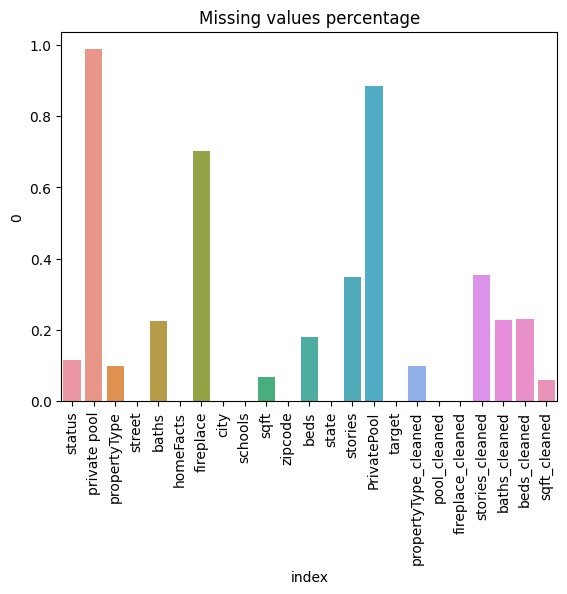

In [438]:
# взглянем еще раз, на то, что удалось добиться к текущему моменту,
# видим признаки с суффиксом cleaned по количеству пропусков не сильно изменились по отношению к исходным
# отлично, значит, нам удалось вытащить нужную информацию, без сильной потери данных по пути.

nan_visual(df)

In [439]:
# Обработаем признак status, в нем аналогично предыдущим признакам, огромное количество неструкрутированной даты

print("Первые 20 элементов признака status")
display(df['status'].value_counts()[:20])

# здесь также нужно применить группировку для данных, где это возможно, 
# самые крупные группы проверить на схожесть в интерпретации и сгруппировать остальные пометим как others

def status_grouper(val):
    
    val_str = str(val).lower()
    
    sale_patern = re.compile(r'for.*sale|active', flags=re.IGNORECASE)
    
    if pd.isna(val):
        return np.nan
    
    if sale_patern.search(val_str):
        return 'for sale'
    
    if 'foreclosure' in val_str:
        return 'foreclosure'
    
    if 'contract' in val_str:
        return 'contract'
    
    return 'others'

df['status_cleaned'] = df['status'].apply(status_grouper)

Первые 20 элементов признака status


status
for sale                     135558
Active                        94288
For sale                      43394
New construction               5458
foreclosure                    4645
Pending                        4212
Pre-foreclosure                2000
P                              1461
Pre-foreclosure / auction      1281
Under Contract Show            1068
 / auction                      799
Under Contract   Showing        748
Active Under Contract           714
New                             672
Under Contract                  663
Contingent                      565
Price Change                    557
Auction                         492
A Active                        369
Foreclosure                     320
Name: count, dtype: int64

In [440]:
# проверим все ли в порядке с признаков state видим что в нем имеется дублика штата FL (флорида)
# это проихошло от того, что написание через маленькую букву l поправим это

print("Выведем уникальные значения признака")
display(np.array(sorted([state for state in df.state.unique()])))

df['state_cleaned'] = df['state'].apply(lambda x: x.upper())

Выведем уникальные значения признака


array(['AZ', 'BA', 'CA', 'CO', 'DC', 'DE', 'FL', 'Fl', 'GA', 'IA', 'IL',
       'IN', 'KY', 'MA', 'MD', 'ME', 'MI', 'MO', 'MS', 'MT', 'NC', 'NJ',
       'NV', 'NY', 'OH', 'OK', 'OR', 'OS', 'OT', 'PA', 'SC', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI'], dtype='<U2')

In [441]:
# предобработаем признак city, проверим есть ли в списке одинаковые города, но по опыту с предыдущим признаком
# написаны разным регистром
# Да, к сожалению эта проблема и не прошла мимо признака city, придется также продумывать логику обработки данного признака

print("Количество уникальных городов в признаке city")
print(df['city'].nunique(), '\n')

print("Количество уникальных городов в признаке city с учетом приведения к нижнему регистру")
print(df['city'].apply(lambda x: str(x).capitalize()).nunique())

# обработаем признак и приведем к единому регистру

df['city_cleaned'] = df['city'].apply(lambda x: str(x).capitalize())

Количество уникальных городов в признаке city
1906 

Количество уникальных городов в признаке city с учетом приведения к нижнему регистру
1795


In [442]:
# Признак homeFacts выглядит как json, но это строка, в ней есть ряд патернов которые нарушают синтаксис json
# для этого напишем функцию и определим патерны которые помогу избежать некоторых ошибок при преобразовании признака в json

home_fact_replace_list = [['None', 'null'],
    ["\'\'", 'null'],
    ["\'", '"'],
    ["'", '"'],
    ['(?<=[a-zA-Z])"(?=[a-zA-Z])', "\'"],
    ['(?<=[a-zA-Z])"(?=-)', ""],
    ['Front room "closet-Electric', 'Front room closet-Electric']
]
    
home_fact_pattern = {re.compile(key): val for key, val in home_fact_replace_list}

def str_to_json_transformer(val, pats):
    
    for pattern, subs in pats.items():
        val = pattern.sub(subs, val)
    try:
        return json.loads(val)
    except:
        return np.nan
    
df['json_home_facts'] = df['homeFacts'].apply(str_to_json_transformer, pats=home_fact_pattern)

In [443]:
# Признак schools также возможно конвертировать в json, но есть аналогичная необходимость обработать данные таким образом
# чтобы данные можно было распознать через библиотеку json, применяем функцию str_to_json_transformer но в этот раз 
# паттерн который использовали для предобработки предыдущего признака нам не подойдет

schools_fact_replace_list = [
    ['None', 'null'],
    ['^\[', ''],
    ['\]$', ''],                        
    ["\'\'", 'null'],
    ["\'", '"'],
    ["'", '"'],
    ['(?<=[a-zA-Z])"(?=[a-zA-Z])', "\'"],
    ['(?<=[a-zA-Z])"(?=-)', ""],
    ['(?<=\s)"(.*?)(?=")(?=\s)', "'"],
    ['(?<=[a-zA-Z])"(?=\s)|(?<=\s)"(?=[a-zA-Z]+"\s)', "'"],
    ["(?<=,\s)'", '"'],
    ['\"s', "\'s"]
]

schools_fact_pattern = {re.compile(key): val for key, val in schools_fact_replace_list}

df['json_schools'] = df['schools'].apply(str_to_json_transformer, pats=schools_fact_pattern)

In [444]:
# Создаем новые признаки на основе признака json_home_facts который мы предобработали на предыдущем шаге

home_feats_list = ['Year built', 'Remodeled year', 
                  'Heating', 'Cooling', 'Parking',
                  'lotsize']


def home_facts_features_extractor(val, feat):
    dcts = val['atAGlanceFacts']
    for dct in dcts:
        try:
            if dct['factLabel'] == feat:
                if dct['factValue'] is None:
                    return np.nan
                if dct['factValue'] == '':
                    return np.nan
                return dct['factValue']
        except:
            return np.nan
    
    
for feat in home_feats_list:
    df[feat] = df['json_home_facts'].apply(home_facts_features_extractor, feat=feat)
    
# Удаляем признак json_home_facts так как извлекли из него все важное
df.drop(['json_home_facts'], axis=1, inplace=True)

In [445]:
# Создадим 4 признака из json schools полученный на предобработке предыдущего этапа

df['school_ratings'] = df['json_schools'].apply(lambda x: x['rating'])
df['school_distances'] = df['json_schools'].apply(lambda x: x['data']['Distance'])
df['school_grades'] = df['json_schools'].apply(lambda x: x['data']['Grades'])
df['school_names'] = df['json_schools'].apply(lambda x: x['name'])

# удаляем признак json_schools т.к. уже все из него извлекли
df.drop(['json_schools'], inplace=True, axis=1)

In [446]:
# перед тем как двигаться дальше в предобработке избавимся от более ненужных нам признаков

feats_to_drop = ['private pool', 'PrivatePool', 'propertyType',
                 'baths', 'sqft', 'schools', 'fireplace', 'homeFacts', 'status',
                 'stories', 'beds', 'city', 'state']

df.drop(feats_to_drop, axis=1, inplace=True)

In [447]:
# Попробуем достать данные из признака lotsize для того чтобы заполнить пропуски в признаки sqft_cleaned

def area_extractor2(col):
    match = re.search(r'\d+([.,]\d+)?', str(col))
    low_val = str(col).lower()
       
    if match and 'acr' in low_val:
        return float(match.group().replace(',', '.')) * 43_560
    
    if match and 'sq' in low_val:
        return float(match.group().replace(',', '.'))
    
    if match:
        return float(low_val.replace(',', ''))


# сразу заполним Nan значения в признаке sqft_cleaned и удалим lotsize
df['sqft_cleaned'] = df['sqft_cleaned'].fillna(df['lotsize'].apply(area_extractor2))
df.drop('lotsize', axis=1, inplace=True)

In [448]:
# Извлечем из признака названия школ, полезные свойства, а именно типы школ, и создадим на их основе новые признаки

school_types = ['high', 'middle', 'elementary', 'primary', 'private', 'ps', 'k12', 'charter', 'special']


def school_level_extractor(val, school_types):
    
    school_types_dict = {school:0 for school in school_types}
    
    for school in val:
        school = str(school).lower()
        
        for key in school_types_dict.keys():
            if key in school:
                school_types_dict[key] += 1
            
    return school_types_dict


schools_types_series = df['school_names'].apply(school_level_extractor, school_types=school_types)

for school in school_types:
    df[school] = schools_types_series.apply(lambda x: x[school])
    
# удаляем признак с названиями школ, больше он нам не понадобится
df.drop('school_names', axis=1, inplace=True)

In [449]:
# Создадим функцию для обработки грейдов школ, выделим из них максимальный и минимальный школьный грейд, для объекта недвижимости
# пустые значения будем сразу заполнять нулями

def min_max_school_grades(val, option):
    
    """Функция получает лист с грейдами и возвращает минимальный и максимальный грейд"""
    
    pattern = re.compile('\d+')
    grades_list = [int(x) for x in pattern.findall(str(val))]

    if option == 'min': return min(grades_list) if grades_list else 0
    if option == 'max': return max(grades_list) if grades_list else 0
    else: return 0
        
    
df['min_school_grades'] = df['school_grades'].apply(min_max_school_grades, option='min')
df['max_school_grades'] = df['school_grades'].apply(min_max_school_grades, option='max')



In [450]:
# Создадим фукнцию для обработки расстояния до школ, и создадим на ее основе несколько признаков,
# Интересно получается у нас, что в предобработке сразу и фича инжениринг

def school_distance_aggregator(val, agg_func):
    pattern = re.compile('\d+([,.]\d+)?')

    distance_list = []
    for elem in val:
        distance_list.append(pattern.search(elem).group())
    return agg_func([float(x) for x in distance_list]) if distance_list else 0

df['school_distances_average'] = df['school_distances'].apply(school_distance_aggregator, agg_func=np.mean)
df['school_distances_min'] = df['school_distances'].apply(school_distance_aggregator, agg_func=np.min)

# удаляем признак school_distances так как извлекли из него нужные нам признаки

df.drop(['school_distances'], axis=1, inplace=True)

In [451]:
# Создаем фукнцию для агрегации рейтинга школ и создаем 3 дополнительных признака

def school_rating_aggregator(val, agg_func):
    num_pat = re.compile('\d+')
    num_list = []
    for num in val:
        val_str = str(num)
        match = num_pat.search(val_str)
        if match and 'null' not in val_str:
            num_list.append(match.group())
    return agg_func([int(x) for x in num_list]) if num_list else 0


df['school_ratings_average'] = df['school_ratings'].apply(school_rating_aggregator, agg_func=np.mean)
df['school_ratings_min'] = df['school_ratings'].apply(school_rating_aggregator, agg_func=np.min)
df['school_ratings_max'] = df['school_ratings'].apply(school_rating_aggregator, agg_func=np.max)

# удаляем признак с рейтингом и грейдами школ, так как мы уже извлекли все основные важные свойства
df.drop(['school_ratings', 'school_grades'], axis=1, inplace=True) 

In [452]:
df.loc[:, :'private'].head()

,street,zipcode,target,propertyType_cleaned,pool_cleaned,fireplace_cleaned,stories_cleaned,baths_cleaned,beds_cleaned,sqft_cleaned,...,Year built,Remodeled year,Heating,Cooling,Parking,high,middle,elementary,primary,private
0,240 Heather Ln,28387,418000,Single Family Home,0,1,NaN,3.5,4.0,2900.0,...,2019,NaN,"Central A/C, Heat Pump",NaN,NaN,2,2,1,1,2
1,12911 E Heroy Ave,99216,310000,Single Family Home,0,0,2.0,3.0,3.0,1947.0,...,2019,NaN,NaN,NaN,NaN,1,1,1,0,0
2,2005 Westridge Rd,90049,2895000,Single Family Home,1,1,1.0,2.0,3.0,3000.0,...,1961,1967,Forced Air,Central,Attached Garage,1,1,0,0,0
3,4311 Livingston Ave,75205,2395000,Single Family Home,0,1,3.0,8.0,5.0,6457.0,...,2006,2006,Forced Air,Central,Detached Garage,2,1,1,0,0
5,1624 S Newkirk St,19145,209000,Townhouse,0,0,2.0,NaN,2.0,897.0,...,1920,NaN,Forced Air,Central,NaN,0,0,0,0,0


In [453]:
# обработаем признак год постройки

# заменим явный выброс и отсутствие данных
df['Year built'] = df['Year built'].replace({'No Data': np.nan, '559990649990': np.nan})

mean_build_year = int(df[df['Year built'].notna()]['Year built'].astype(int).mean())
df['Year built'] = df['Year built'].fillna(mean_build_year)

# Продолжим обработку данных заполним пропуски в признаке Remodeled Year 

df['Remodeled year'] = df['Remodeled year'].fillna(df['Year built'])

df['Remodeled year'] = df['Remodeled year'].astype(int)

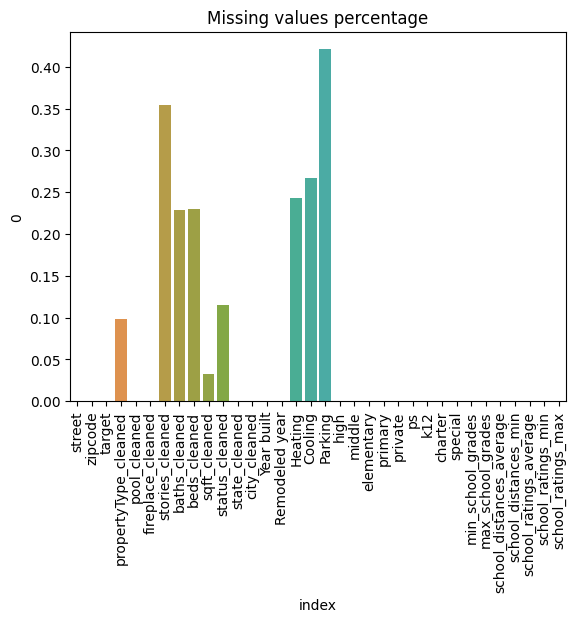

In [454]:
# Выведем еще раз что у нас осталось обработать
nan_visual(df)

In [455]:
# Заполним пропуски в propertyType_cleaned 

df['propertyType_cleaned'] = df['propertyType_cleaned'].fillna('mode')

In [456]:
df.columns

Index(['street', 'zipcode', 'target', 'propertyType_cleaned', 'pool_cleaned',
       'fireplace_cleaned', 'stories_cleaned', 'baths_cleaned', 'beds_cleaned',
       'sqft_cleaned', 'status_cleaned', 'state_cleaned', 'city_cleaned',
       'Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'high',
       'middle', 'elementary', 'primary', 'private', 'ps', 'k12', 'charter',
       'special', 'min_school_grades', 'max_school_grades',
       'school_distances_average', 'school_distances_min',
       'school_ratings_average', 'school_ratings_min', 'school_ratings_max'],
      dtype='object')

In [457]:
# заполним пропуски для признака stories_cleaned но сначала посмотрим что там с выбросами
# видно есть есть недвижимость где больше 1000 этажей
# Заменим такие пропуски на nan
# найдем средние значения по этажности по городам и заполним пропуски 
# оставшиеся пропуски заполним средними значениями

print(df[df['stories_cleaned'].notna()]['stories_cleaned'].astype(np.int32).unique())

df.loc[df['stories_cleaned'] > 1000, 'stories_cleaned'] = np.nan

missed_stories = df.groupby('city_cleaned')['stories_cleaned']\
    .transform(lambda x: int(x.mean(skipna=True)) if not np.isnan(x.mean(skipna=True)) else np.nan)
    
df['stories_cleaned'] = df['stories_cleaned'].fillna(missed_stories)
df['stories_cleaned'] = df['stories_cleaned'].fillna(int(df['stories_cleaned'].mean()))

[   2    1    3    4    0    9   14    5    7   15   22    6   54   23
    8   16   18   21   12   11   28   17   63   27   19   20   13   51
   31   46   70   25   33   10   95   90   91   35   24   38   26   30
   36   42   45   29   55   78   56   47   40   43   80   34   32   57
   41   39   64   48   58   52   37   50   44   68   60   77   75   66
   62   82   49 1120 1002   96   65]


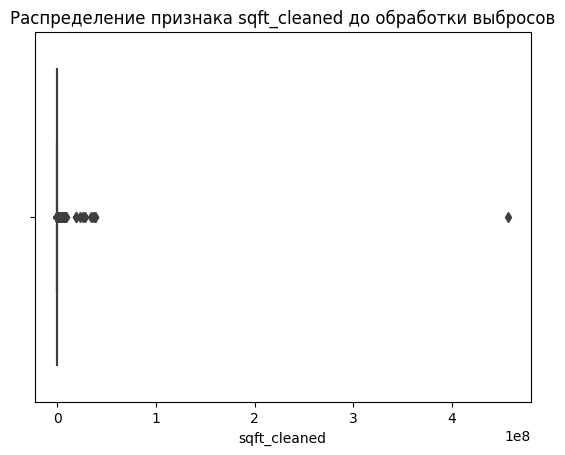

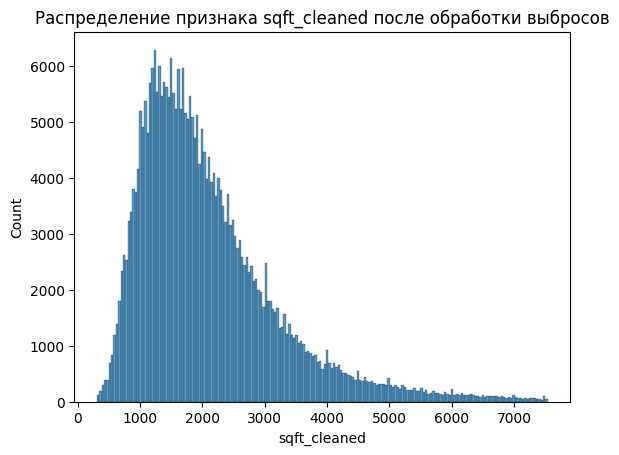

In [458]:
# обработам признак площади sqft_cleaned

sns.boxplot(df, x='sqft_cleaned')
plt.title('Распределение признака sqft_cleaned до обработки выбросов')
plt.show()

# видим, что есть явный выброс в максимальной точке


# df.drop(df[df['sqft_cleaned'] == df['sqft_cleaned'].max()].index, axis=0, inplace=True) # удаляем этот выброс
# df.drop(df[df['sqft_cleaned'] == 0].index, axis=0,  inplace=True) # удалим выбросы где площадь недвижимости отсутствует

sq_mean = df['sqft_cleaned'].mean()
sq_q25 = df['sqft_cleaned'].quantile(.25)
sq_q75 = df['sqft_cleaned'].quantile(.75)
iqr = sq_q75 - sq_q25

lower_bound  = sq_q25 - 0.7*iqr # если провести эксперименты то видно, что на графике ниже что много околонулевых значений, которые моментально создают выбросы
upper_bound = sq_q75 + 3.5*iqr # верхняя граница более широкая, поэтому используем коэффициен 3.5 на графике наглядно видно, что львиная доля объектов если это не выбросы убывает до нуля почти в этой области

sns.histplot(df[(df['sqft_cleaned'] >= lower_bound) & (df['sqft_cleaned'] <= upper_bound)], x='sqft_cleaned')
plt.title('Распределение признака sqft_cleaned после обработки выбросов')
plt.show()

df.drop(df[~((df['sqft_cleaned'] >= lower_bound) & (df['sqft_cleaned'] <= upper_bound))].index, axis=0, inplace=True)

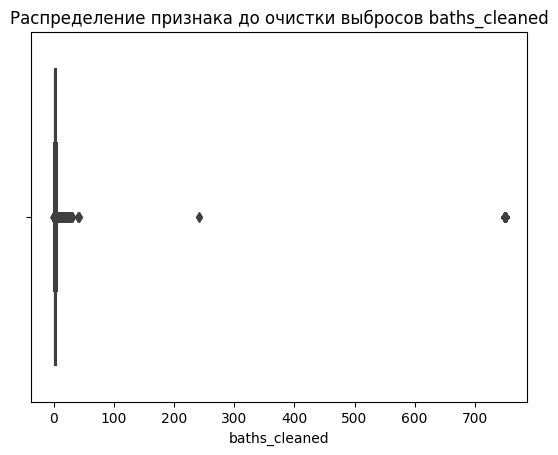

propertyType_cleaned
Condominium           4.453826
Multi Family Home     3.396133
Single Family Home    2.804916
Townhouse             2.961951
Traditional Home      5.815399
mode                  8.319474
others                5.994483
Name: baths_cleaned, dtype: float64


In [459]:
# Продолжаем заполнять пропуски и переходим к признаку baths_cleaned
# видим что тут есть очевидно 2 выброса

sns.boxplot(df[df['baths_cleaned'].notna()], x='baths_cleaned')
plt.title('Распределение признака до очистки выбросов baths_cleaned')
plt.show()

# Видим что в признаке имеются выбросы которые силооно искажают реальную картину

# Посмотрим может по признаку типа собственности есть разница в средних значениях ванн и возможно выбросы не выбросы
# видим что в данном случае выбросы являются тем чем являются
print(df[df['baths_cleaned'].notna()].groupby(['propertyType_cleaned'])['baths_cleaned'].mean())

df.drop(df[df['baths_cleaned'] > 100].index, axis=0, inplace=True) # удаляем такие признаки



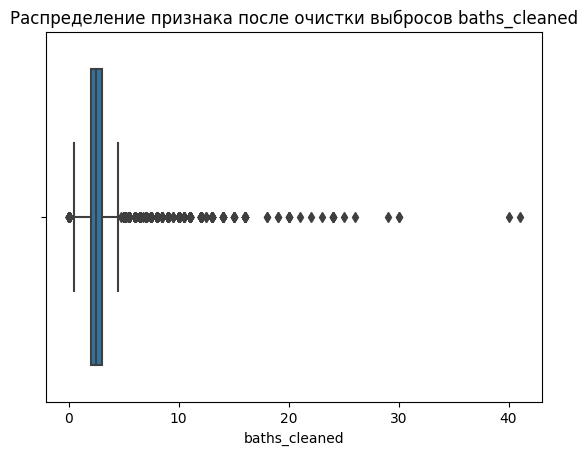

Корреляция между признаками количества ванных и площади -> 0.74
Абсолютная ошибка по предсказанию количество ванн -> 0.53


In [460]:
# # Построим еще один боксплот чтобы посмотреть как выглядит распределение признака уже после очистки
sns.boxplot(df[df['baths_cleaned'].notna()], x='baths_cleaned')
plt.title('Распределение признака после очистки выбросов baths_cleaned')
plt.show()

# # все равно видим, что как будто есть выбросы, но если подетальнее посмотреть, то это не выбросы вовсе, 
# # эти данные о много-семейных (мультиквартирный надо полагать) домах, так что да совокупно могут быть такие показатели

 
# # посмотрим есть ли зависимость количества ванн от площади, видим что есть корреляция,
# # Ага, видим высокую степерь корреляции между признаками, построим линейную регрессию и заполним пустые значения для baths
print("Корреляция между признаками количества ванных и площади ->", round(df[['sqft_cleaned', 'baths_cleaned']].corr()['baths_cleaned'][0], 2))


# Будем использовать данный признак для простоты, так как он с высокой степенью линейно зависим
# В теории мы могли бы добавить сюда еще признаков и построить более качественные предсказания, 
# но у нас много признаков с пропусками, так что используем пока так

X_train = df[df['baths_cleaned'].notna()]['sqft_cleaned'].values.reshape(-1, 1)[:200_000]
X_test = df[df['baths_cleaned'].notna()]['sqft_cleaned'].values.reshape(-1, 1)[200_000:]

y_train = df[df['baths_cleaned'].notna()]['baths_cleaned'][:200_000]
y_test = df[df['baths_cleaned'].notna()]['baths_cleaned'][200_000:]


lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)


print("Абсолютная ошибка по предсказанию количество ванн ->", round(mean_absolute_error(y_true=y_test, y_pred=y_pred), 2))
# метрика получается достаточно хорошая, в среднем модель ошибается в пол-ванны (если так вообще можно сказать)

sqft_for_nan_bath = df[df['baths_cleaned'].isna()]['sqft_cleaned']

y_pred_na = lin_reg.predict(sqft_for_nan_bath.values.reshape(-1, 1))


# заполняем пропуски предсказаниями
df['baths_cleaned'] = df['baths_cleaned'].fillna(pd.Series(np.round(y_pred_na, 0), sqft_for_nan_bath.index)) 


Статистики по распределению признака beds_cleaned count    251790.000000
mean          3.339010
std           3.637582
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max         871.000000
Name: beds_cleaned, dtype: float64


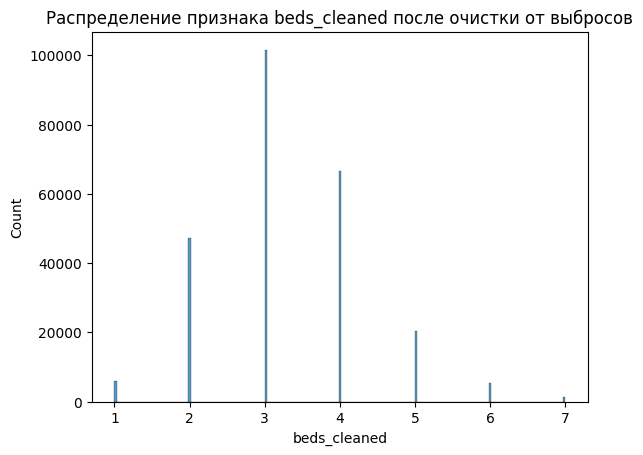

Количество выбросов 2965


In [461]:
# Продолжаем заполнять пропуски, для признака beds_cleaned но для начала устраним выбросы

df_beds_notna = df[df['beds_cleaned'].notna()]

print("Статистики по распределению признака beds_cleaned", df_beds_notna['beds_cleaned'].describe())

# По аналогии с признаков sqft_cleaned применим метод 3х сигм, оптимизируем их под данные на визуальном графике

beds_mean = df_beds_notna['beds_cleaned'].mean()
q1_beds = df_beds_notna['beds_cleaned'].quantile(.25)
q3_beds = df_beds_notna['beds_cleaned'].quantile(.75)
iqr = q3_beds - q1_beds
lower_bound = q1_beds - 2*iqr
upper_bound = q3_beds + 3*iqr


outliers_filter = (df_beds_notna['beds_cleaned'] >= lower_bound) & (df_beds_notna['beds_cleaned'] <= upper_bound)

# Распределение дискретное, выглядит похожим на нормальное со смещением вправо
sns.histplot(df_beds_notna[outliers_filter], x='beds_cleaned')
plt.title("Распределение признака beds_cleaned после очистки от выбросов")
plt.show()

# После применении метода 3х сигм выбросов получилось около 3х тысяч, можно их удалить
print("Количество выбросов", df_beds_notna[~outliers_filter].shape[0])

# удаляем выбросы
df.drop(df_beds_notna[~outliers_filter].index, axis=0, inplace=True)


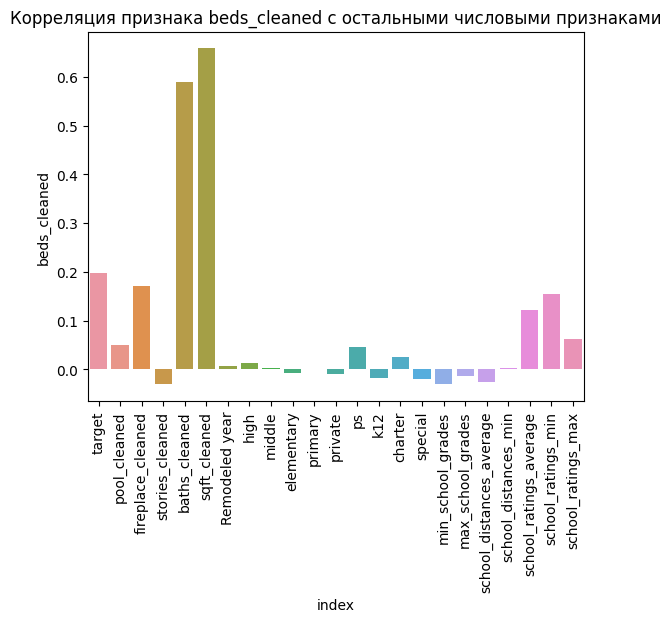

MAPE 0.16856382934787098


In [462]:
# # построим корреляционную матрицу с другими признаками и построим график
beds_cleaned_corr = df[df['beds_cleaned'].notna()].select_dtypes(exclude=['object'])\
    .corr().loc['beds_cleaned'].drop('beds_cleaned').reset_index()

sns.barplot(beds_cleaned_corr, x='index', y='beds_cleaned')
plt.xticks(rotation=90)
plt.title('Корреляция признака beds_cleaned с остальными числовыми признаками')
plt.show()

# # У нас имеется достаточно высокая корреляция с признаками количества ванных комнат и площади жилья,
# # Построим на их основе модель линейной регрессии и заполним признаки

# Используем тяжелую артелерию, а именно градиентный бустинг, попробуем довести mape
# до значений ниже 20%

grad_boost_beds = GradientBoostingRegressor(n_estimators=500, max_depth=5, random_state=42)

X_train = df[df['beds_cleaned'].notna()][['sqft_cleaned', 'baths_cleaned']].iloc[:220000]
X_test = df[df['beds_cleaned'].notna()][['sqft_cleaned', 'baths_cleaned']].iloc[220000:]
y_train = df[df['beds_cleaned'].notna()]['beds_cleaned'].iloc[:220000]
y_test = df[df['beds_cleaned'].notna()]['beds_cleaned'].iloc[220000:]

grad_boost_beds.fit(X_train, y_train)

y_pred = grad_boost_beds.predict(X_test)

# Проверим качество предсказаний, получаем метрику ниже 20% то что нам и нужно 
print("MAPE", mean_absolute_percentage_error(y_test, np.round(y_pred)))


X_missing_beds = df[df['beds_cleaned'].isna()][['sqft_cleaned', 'baths_cleaned']]

beds_nan_pred = np.round(grad_boost_beds.predict(X_missing_beds), 0)

df['beds_cleaned'] = df['beds_cleaned'].fillna(pd.Series(beds_nan_pred, X_missing_beds.index))

In [463]:
# продолжаем заполнять пропуски заполним признак status_cleaned, модельным значением
df['status_cleaned'] = df['status_cleaned'].fillna(df['status_cleaned'].mode().values[0])

In [464]:
# Сгруппируем данные в признаке отопление

def heating_grouper_func(val):
    
    if pd.isna(val):
        return val
    
    val_low = val.lower()
    
    if 'forced' in val_low:
        return 'Forced Air'
    if 'central' in val_low and 'electric' in val_low:
        return 'Central Electric'
    if 'central air' in val_low:
        return 'Central'
    if 'no data' in val_low:
        return 'Other'
    if 'gas' in val_low:
        return 'Gas'
    if 'heat' in val_low:
        return 'Heat'
    if 'electric' in val_low:
        return 'Central Electric'
    if 'central furnace' in val_low:
        return 'Central'
    else: 
        return 'Other'
    
      
df['Heating'] = df['Heating'].apply(heating_grouper_func)

# Заполним модой пропущенные значения по признаку heating
df['Heating'] = df['Heating'].fillna(df['Heating'].mode()[0])

In [465]:
# Делаем группировку признака Cooling и заполняем пустые значения

def cooling_grouper_func(val):
    
    if pd.isna(val):
        return val
    
    val_low = val.lower()
    
    if 'null' in val_low:
        return np.nan
    if 'central' in val_low:
        return 'Central'
    return 'Other'
    
    
df['Cooling'] = df['Cooling'].apply(cooling_grouper_func)
# заполняем модальным значением пропуски
df['Cooling'] = df['Cooling'].fillna(df['Cooling'].apply(cooling_grouper_func).mode()[0])

    

In [466]:
# Создадим функцию для группировки значений по признаку парковка, и заполним пустые значения модальным занченим 


def parking_groper(val):
    
    if pd.isna(val):
        return np.nan
    
    val_low = str(val).lower()
    
    if 'null' in val_low:
        return np.nan
    
    pattern = re.compile('\d+')
    match = pattern.match(val_low)
    
    if match:
        if int(match.group()) >= 10:
            return 'big parking lot'
        if match.group()!='0':
            return f'{match.group()} spaces'
        else: 
            return np.nan 
        
    if 'no data' in val_low:
        return np.nan
    if 'attached garage' in val_low:
        return 'attached garage'
    if 'detached garage' in val_low:
        return 'detached garage'
    
    return 'Other'


# Применяем функцию и заполняем пустые значения
df['Parking'] = df['Parking'].apply(parking_groper)
df['Parking'] = df['Parking'].fillna(df['Parking'].apply(parking_groper).mode()[0])


In [467]:
# у нас остался один признак в которое есть пропущенные значения это признак street
print(df.isna().sum())

# удалим его
df.drop(df[df['street'].isna()].index, axis=0, inplace=True)

street                      0
zipcode                     0
target                      0
propertyType_cleaned        0
pool_cleaned                0
fireplace_cleaned           0
stories_cleaned             0
baths_cleaned               0
beds_cleaned                0
sqft_cleaned                0
status_cleaned              0
state_cleaned               0
city_cleaned                0
Year built                  0
Remodeled year              0
Heating                     0
Cooling                     0
Parking                     0
high                        0
middle                      0
elementary                  0
primary                     0
private                     0
ps                          0
k12                         0
charter                     0
special                     0
min_school_grades           0
max_school_grades           0
school_distances_average    0
school_distances_min        0
school_ratings_average      0
school_ratings_min          0
school_rat

In [468]:
# уберем из названия признаков суффикс _cleaned
cols_list = []
for col in df.columns:
    if '_cleaned' in col:
        cols_list.append(col.split('_cleaned')[0])
    else:
        cols_list.append(col)
        
df.columns = cols_list

In [469]:
# Признак Year built приведем в формат целочисленного значения
df['Year built'] = df['Year built'].astype(int)

# остальные признаки с типом данных object приведет к строковым значениям
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str)

Итак подведем небольшой промежуточный результат, что удалось добиться к текущему моменту, произвели очистку для признаков:
- Провели первичную очистку данных от выбросов включая целевой признак
- Заполнили пустые значения по признакам
- Провели первичный фича-инжениринг, распаковали признаки json
- Первично обработали выбросы для заполнения nan значений
- Извлекли полезные свойства из скученных данных
- Сгруппировали категории внутри категориальных признаков
  



### <center> **3. Exploratory Data Analysis - Разведывательный анализ данных** </center>

In [470]:
# Посмотрим еще раз статистики для датасета, после предобработки

df.describe()

,target,pool,fireplace,stories,baths,beds,sqft,Year built,Remodeled year,high,...,k12,charter,special,min_school_grades,max_school_grades,school_distances_average,school_distances_min,school_ratings_average,school_ratings_min,school_ratings_max
count,3.085620e+05,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,...,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000,308562.000000
mean,5.669512e+05,0.135331,0.307857,1.814092,2.637734,3.232723,2084.882215,1980.354823,1983.361490,1.181928,...,0.000162,0.059700,0.005159,5.092176,11.768001,2.764690,1.103944,5.125234,3.679345,6.689262
std,1.060204e+06,0.342077,0.461608,2.544795,1.088894,1.027346,1115.719966,32.156402,53.454915,0.854878,...,0.012729,0.316398,0.072409,1.453718,1.335836,6.302363,5.792515,1.991860,2.069354,2.390487
min,1.000000e+04,0.000000,0.000000,0.000000,0.000000,1.000000,306.000000,1019.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.150000e+05,0.000000,0.000000,1.000000,2.000000,3.000000,1298.000000,1960.000000,1969.000000,1.000000,...,0.000000,0.000000,0.000000,5.000000,12.000000,1.033333,0.350000,3.666667,2.000000,5.000000
50%,3.363500e+05,0.000000,0.000000,1.000000,2.000000,3.000000,1824.000000,1983.000000,1988.000000,1.000000,...,0.000000,0.000000,0.000000,5.000000,12.000000,1.700000,0.630000,5.000000,3.000000,7.000000
75%,5.750000e+05,0.000000,1.000000,2.000000,3.000000,4.000000,2566.000000,2006.000000,2007.000000,1.000000,...,0.000000,0.000000,0.000000,5.000000,12.000000,3.060000,1.200000,6.500000,5.000000,9.000000
max,6.375000e+07,1.000000,1.000000,96.000000,41.000000,7.000000,7544.000000,2025.000000,2025.000000,12.000000,...,1.000000,4.000000,2.000000,12.000000,12.000000,1590.830000,1590.380000,10.000000,10.000000,10.000000


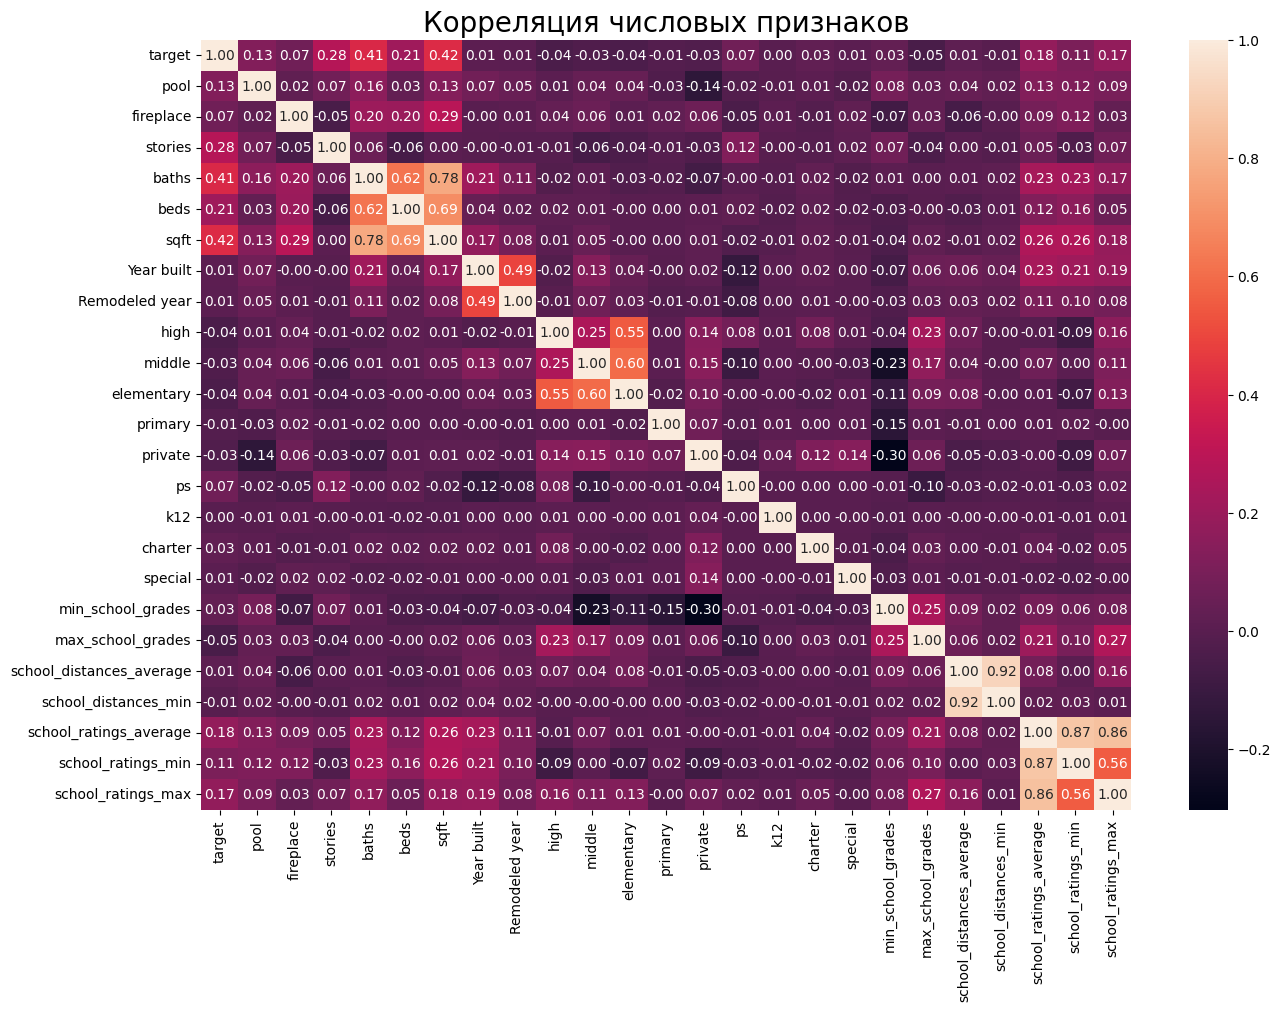

In [471]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.select_dtypes(exclude='O').corr(), annot=True, fmt='.2f')
plt.title("Корреляция числовых признаков", fontdict={'fontsize':20})
plt.show()

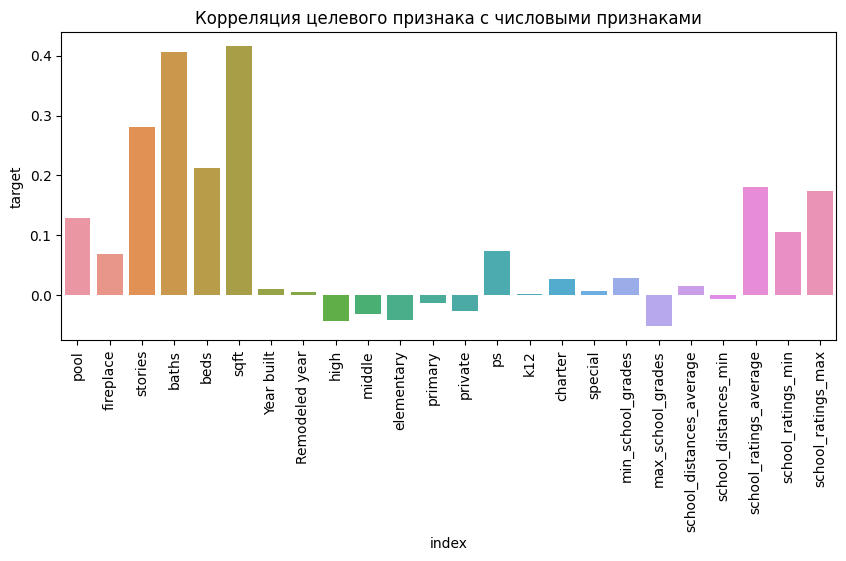

In [472]:
# Построим график корреляции по признакам посмотрим степень корреляции по целевой переменной

plt.figure(figsize=(10, 4))
sns.barplot(df.select_dtypes(exclude='O').corr()['target'].drop('target').reset_index(),
            x='index', y='target')
plt.xticks(rotation=90)
plt.title("Корреляция целевого признака с числовыми признаками")
plt.show()

# В целом корреляция не выглядит очень существенной, вполне позможно требуется дополнительное изучение данных на предмет выбросов
# а также дополнительный фича-инжениринг или же в данных есть нелинейные зависимости

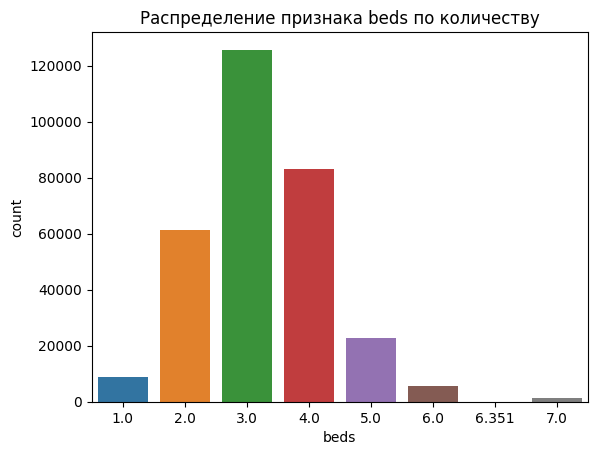

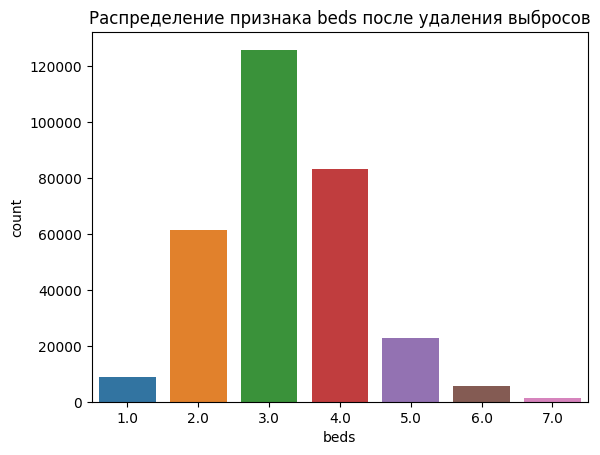

In [473]:
# Обработаем от выбросов признак beds так как на статистике у нас есть объекты с 0 коливеством 
# такого просто не может быть

sns.barplot(df['beds'].value_counts().reset_index(), x='beds', y='count')
plt.title('Распределение признака beds по количеству')
plt.show()

# у нас есть по 1 признак с 0 значение и со значением 6.351 удалим такие наблюдения
df.drop(df[df['beds'].isin([0, 6.351])].index, axis=0, inplace=True)

# выглядит очень похожим на нормальное распределение имеем небольшой хвост в правую сторону
sns.barplot(df['beds'].value_counts().reset_index(), x='beds', y='count')
plt.title('Распределение признака beds после удаления выбросов')
plt.show()

In [474]:
# Данных имеются выбросы, поэтому продолжим работать с ними и для этого напишем функцию которая будет работать с межквартильным размахом

def remove_outliers_iqr(df: pd.DataFrame, feature_name: str, 
                        lower_bound_scaler: float|int = 1.5, 
                        upper_bound_scaler: float|int = 1.5,
                        use_log=False):
    
    """Args:
    df: pd.DataFrame -> as pandas DataFrame
    feature_name: Series Name of the dataframe
    lower_bound_scaler: lower bound of the outliers seeking
    upper_bound_scaler: upper bound of the outliers seeking

    Returns: tuple with filtered dataframe, outliers number & outliers indexes for easy delete option"""
    
    series = np.log(df[feature_name]) if use_log else df[feature_name]
        
    mean = series.mean()
    q25 = series.quantile(.25)
    q75 = series.quantile(.75)
    iqr = q75 - q25
    
    lower_bound = q25 - lower_bound_scaler*iqr
    upper_bound = q75 + upper_bound_scaler*iqr
    filter = (series >= lower_bound) & (series <= upper_bound)
    
    outliers_num = df[~filter].shape[0]
    ountliers_indexes = df[~filter].index
    
    return (df[filter][feature_name], outliers_num, ountliers_indexes)

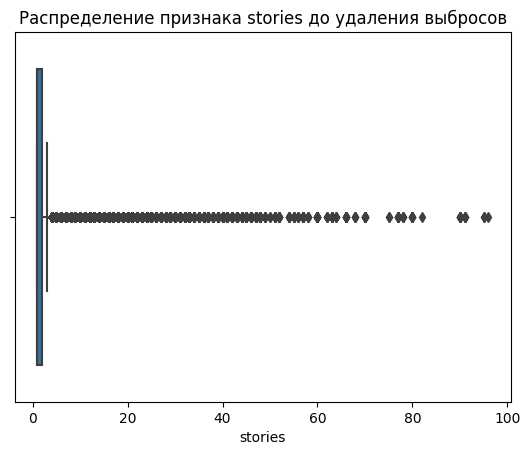

удаляем выбросы по признаку количества этажей -> 7757


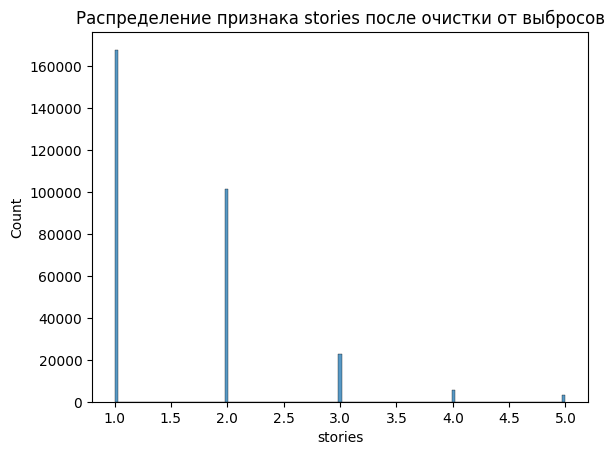

In [475]:
# Признак stories тоже обработаем, несмотря на то, что на предыдущем этапе мы уже прооводили первичную предобработку от выбросов
# в признаке имеются нулевые этажи, предположим что так обозначали дома с одним этажом
df.loc[df['stories'] == 0, 'stories'] = 1

# признак имеет не все значения целочисленные, округлим
df['stories'] = df['stories'].apply(lambda x: round(x, 0))

# Посмотрим на признак детальнее видно сильное смещение вправо
sns.boxplot(df, x='stories')
plt.title('Распределение признака stories до удаления выбросов')
plt.show()

ountliers_num = remove_outliers_iqr(df, 'stories', upper_bound_scaler=3)[1]

print("удаляем выбросы по признаку количества этажей ->", ountliers_num)



sns.histplot(remove_outliers_iqr(df, 'stories', upper_bound_scaler=3)[0])
plt.title('Распределение признака stories после очистки от выбросов')
plt.show()

# удаляем выбросы по признаку stories
df.drop(remove_outliers_iqr(df, 'stories', upper_bound_scaler=3)[2], axis=0, inplace=True)


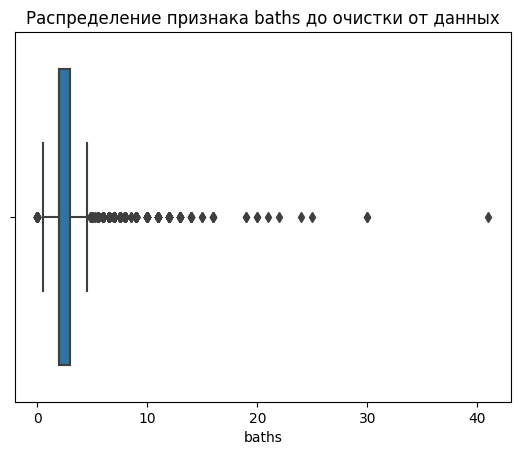

Количетсво выбросов по признаку baths -> 2446


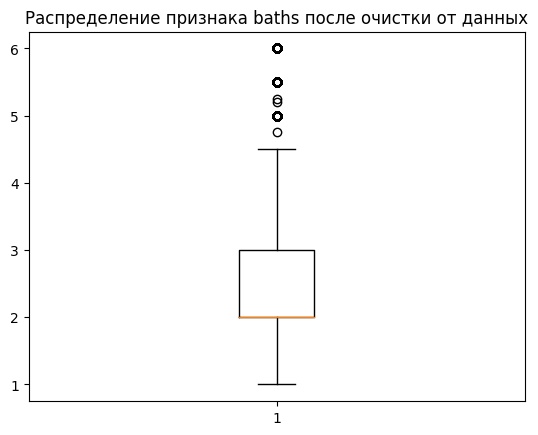

In [476]:
# Продолжаем финально очищать признаки от выбросов, посмотрим на признак ванных комнат
# в США существует стандарт подсчета неполных ванных комнат, а значит нецелые числа будут являться нормой

sns.boxplot(df, x='baths')
plt.title('Распределение признака baths до очистки от данных')
plt.show()

# применим функцию очистки выбросов с помощью iqr
print("Количетсво выбросов по признаку baths ->", remove_outliers_iqr(df, 'baths', lower_bound_scaler=1.1, upper_bound_scaler=3)[1])


df.drop(remove_outliers_iqr(df, 'baths', lower_bound_scaler=1.1, upper_bound_scaler=3)[2], axis=0, inplace=True)

plt.boxplot(remove_outliers_iqr(df, 'baths', lower_bound_scaler=1.1, upper_bound_scaler=3)[0])
plt.title('Распределение признака baths после очистки от данных')
plt.show()

In [477]:
# уберем из дата-сета данные где года построики старше года реновации
df = df.loc[~(df['Year built'] > df['Remodeled year'])]

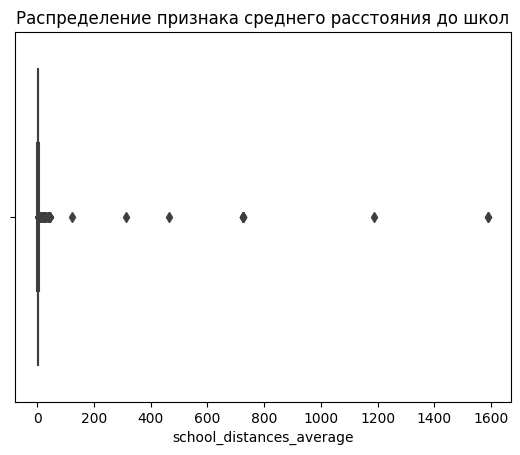

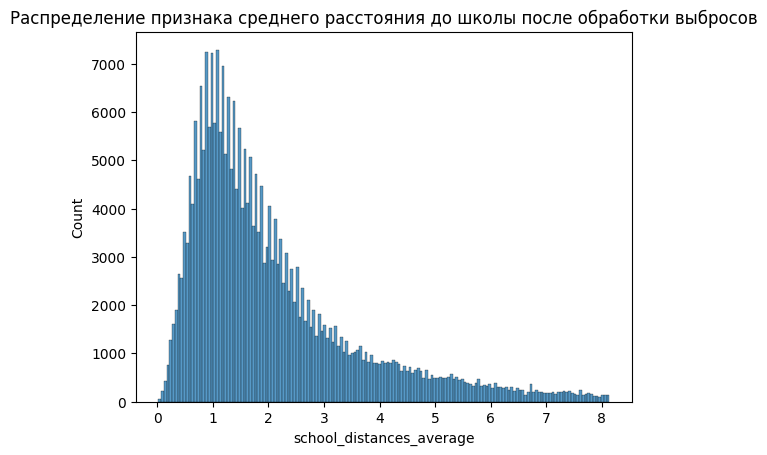

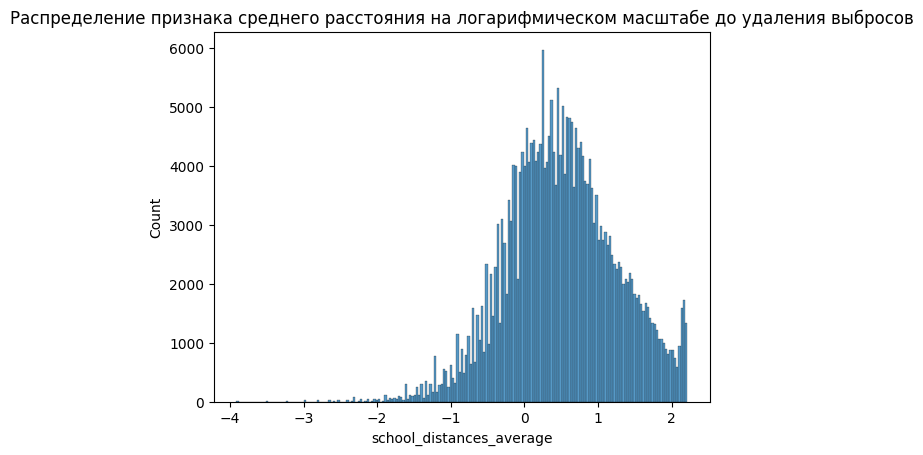

Количество выбросов в признаке среднего расстояния до школы 23765


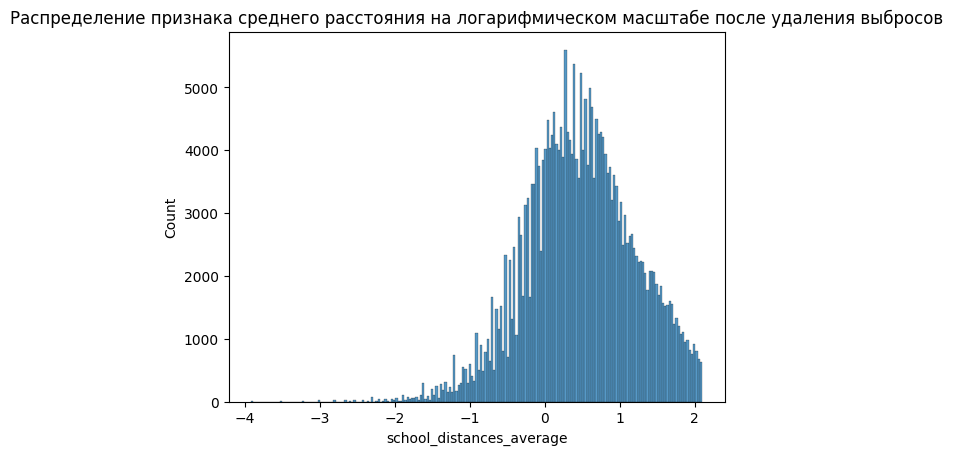

In [478]:
# Посмотрим на распределение признака среднего расстояния до школы
# в признаке явно присутствуют выбросы

sns.boxplot(df, x='school_distances_average')
plt.title('Распределение признака среднего расстояния до школ')
plt.show()


lower_bound = 0.5
upper_bound = 2.5
outliers = remove_outliers_iqr(df, 'school_distances_average', lower_bound_scaler=lower_bound, upper_bound_scaler=upper_bound)

sns.histplot(outliers[0])
plt.title("Распределение признака среднего расстояния до школы после обработки выбросов")
plt.show()


# интересно что если прологарифмировать распределение и сделать правую границу выше 3х то видно что в целом признак становится похожим на нормальное распределение
# но выше границы 2.5 значения начинают резко взлетать вверх, по сути эти значения будут вводить модель в заблуждение
sns.histplot(np.log(remove_outliers_iqr(df, 'school_distances_average', lower_bound_scaler=lower_bound, upper_bound_scaler=3)[0]))
plt.title("Распределение признака среднего расстояния на логарифмическом масштабе до удаления выбросов")
plt.show()

print("Количество выбросов в признаке среднего расстояния до школы", outliers[1])

# удалим такие выбросы
df.drop(outliers[2], axis=0, inplace=True)


sns.histplot(df, x=np.log(df['school_distances_average']))
plt.title("Распределение признака среднего расстояния на логарифмическом масштабе после удаления выбросов")
plt.show()


In [479]:
# Признак k12, private, primary связанные с образованием вообще не информативные по большому счету состоят из нулей, удалим их

print(df['k12'].value_counts())
print(df['private'].value_counts())
print(df['primary'].value_counts())

df.drop(['k12', 'private', 'primary'], axis=1, inplace=True)

k12
0    271415
1        48
Name: count, dtype: int64
private
0    235438
2     33441
1      2551
3        33
Name: count, dtype: int64
primary
0    269117
1      2271
2        75
Name: count, dtype: int64


Количество выбросов по целевому признаку target для очистки -> 35686


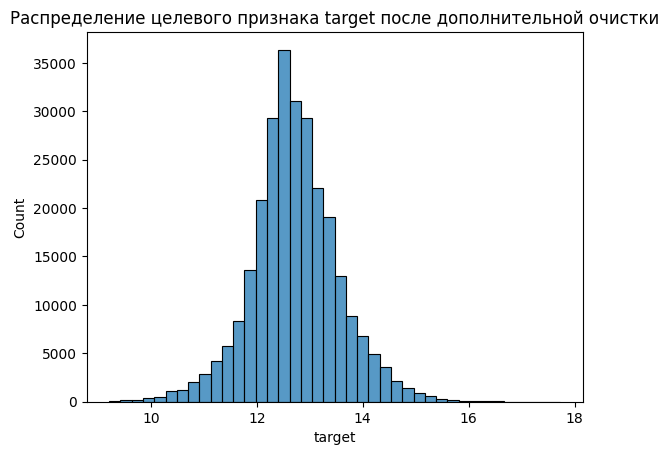

In [480]:
# попробуем дополнительно подчистить целевой признак

lower_bound = 0.8
upper_bound = 0.8

non_outliers_array, outliers_nums, outliers_idx = remove_outliers_iqr(df, 'target', lower_bound_scaler=lower_bound,
                                       upper_bound_scaler=upper_bound, use_log=True)

sns.histplot(df.loc[~df.index.isin(outliers_idx)], x=np.log(df['target']), bins=40)
plt.title("Распределение целевого признака target после дополнительной очистки")

print(f"Количество выбросов по целевому признаку target для очистки -> {outliers_nums}")

df = df.drop(outliers_idx, axis=0)


In [481]:
# Посмотрим на категориальные признаки
df.select_dtypes(include='O').describe()

,street,zipcode,propertyType,status,state,city,Heating,Cooling,Parking
count,235777,235777,235777,235777,235777,235777,235777,235777,235777
unique,208803,4077,7,4,34,1530,6,2,13
top,Address Not Disclosed,78245,Single Family Home,for sale,TX,Houston,Forced Air,Central,attached garage
freq,366,1279,146073,215117,63682,18153,146516,209167,159052


In [482]:
# Признак улицы имеет очень большую уникальность, обобщающая способность в данном случае будет минимальная или отсутствовать вовсе
# удалим его 
df = df.drop(['street'], axis=1)

In [483]:
# В США zipcode кодирует местность, первые 3 цифры делают некое обобщение
# снизим вариативность признака zipcode проведя фича инжениринг
df['zipcode_area'] = df['zipcode'].apply(lambda x: x[:3])

# удаляем более ненужный признак
# df.drop('zipcode', axis=1, inplace=True)

Single Family Home
others
mode
Multi Family Home
Condominium
Townhouse
Traditional Home


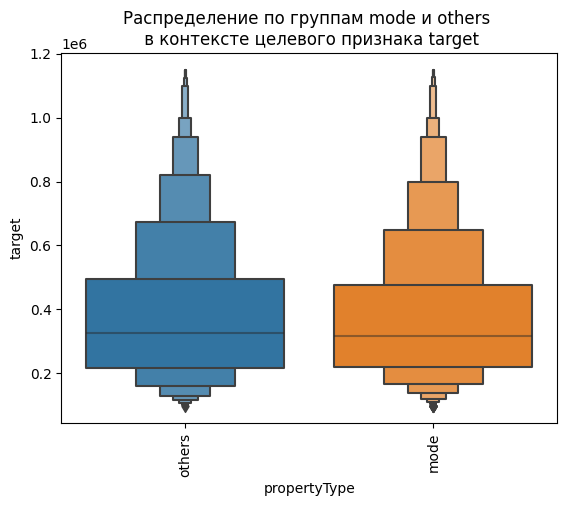

Groups others & mode statisticaly equal (p_value=0.118)


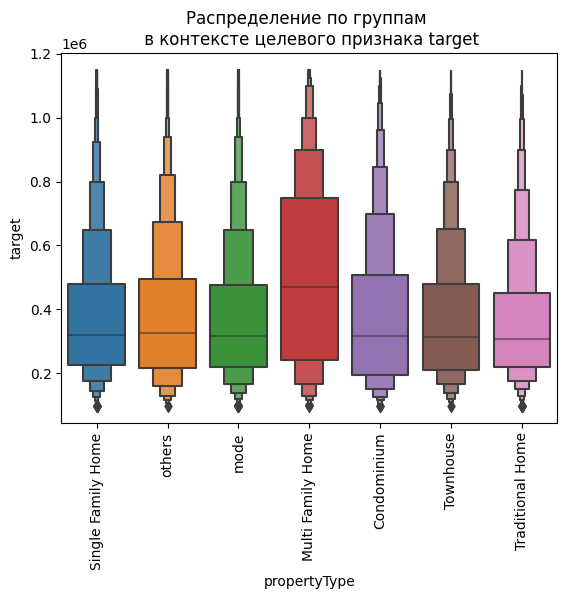

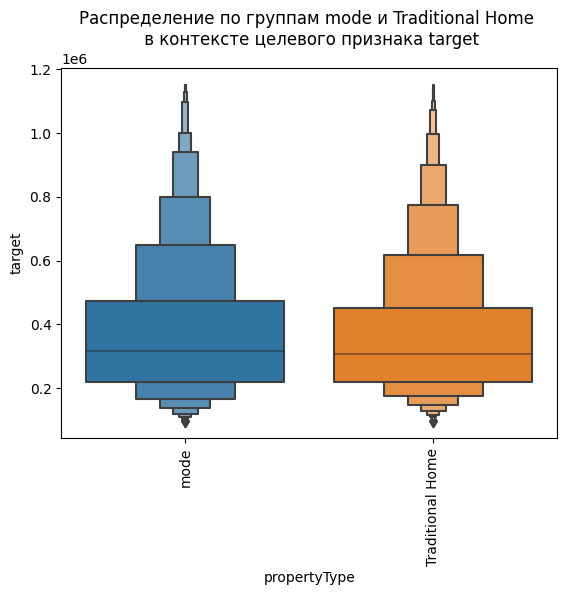

Groups mode & Traditional Home statisticaly equal (p_value=0.052)


In [484]:
# посмотрим на признак propertyType
# у нас есть непонятное значение mode, вероятно это тоже самое что и others
print(*df['propertyType'].unique(), sep='\n')

# посмотрим детальнее на others и mode с точки зрения распределения целевого признака
# Визуально они очень похожи
sns.boxenplot(df.query("propertyType in ['mode', 'others']"), x='propertyType', y='target')
plt.title("Распределение по группам mode и others \n в контексте целевого признака target")
plt.xticks(rotation=90)
plt.show()

# сделаем стат тест чтобы проверить чо распределения по группам  равны
# поскольку целевой признак у нас не распределен нормально используем U test, (даже на боксплотах видно что распределение скорее лог нормальное, но по тестам и оно не проходит)

def u_test(df: pd.DataFrame, 
           feature: str,
           distr_feature: str,
           groups: list, 
           alternative: str = 'two-sided'
           ):
    
    alpha = 0.05
    data_list = []
    
    for group in groups:
        data_list.append(df.loc[df[feature] == group][distr_feature])
        
    x1, x2 = data_list

    _, p_value = mannwhitneyu(x1, x2, alternative=alternative)
    
    if p_value <= alpha:
        return f'Groups {" & ".join(groups)} has statisticaly difference (p_value={p_value:.3f})'
    return f'Groups {" & ".join(groups)} statisticaly equal (p_value={p_value:.3f})'
    
   
# однако по тесту так и не скажешь :) 
print(u_test(df, 'propertyType', 'target', ['others', 'mode']))
    
       
# посмотрим как выглядят остальные признаки 
sns.boxenplot(df, x='propertyType', y='target')
plt.title("Распределение по группам \n в контексте целевого признака target")
plt.xticks(rotation=90)
plt.show()

# на графиках очень похожими выглядят еще mode Traditional Home
sns.boxenplot(df.query("propertyType in ['mode', 'Traditional Home']"), x='propertyType', y='target')
plt.title("Распределение по группам mode и Traditional Home \n в контексте целевого признака target")
plt.xticks(rotation=90)
plt.show()

# получается что статистически mode очень близко по распределению к Traditional Home
print(u_test(df, 'propertyType', 'target', ['mode', 'Traditional Home']))

# заменяем значение группы mode на Traditional Home
df['propertyType'] = df['propertyType'].replace({'mode': 'Traditional Home'})


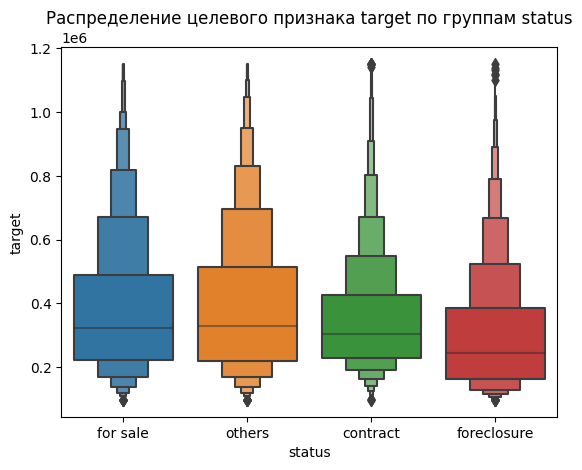

Groups for sale & others has statisticaly difference (p_value=0.003)
Groups for sale & contract has statisticaly difference (p_value=0.000)


In [485]:
# посмотрим распределение целевого признака по признаку status
sns.boxenplot(df, x='status', y='target')
plt.title("Распределение целевого признака target по группам status")
plt.show()

# очень похожими с точки зрения распределения выглядят группы for sale и others проверим их тестом
print(u_test(df, 'status', 'target', ['for sale', 'others']))

# однако по статтесту оказывается что признаки contract и for sale не имеют ститистически значимых различий 
print(u_test(df, 'status', 'target', ['for sale', 'contract']))

# объединим их в одну группу

df['status'] = df['status'].replace({'for sale': 'for_sale_or_contract', 'contract': 'for_sale_or_contract'})

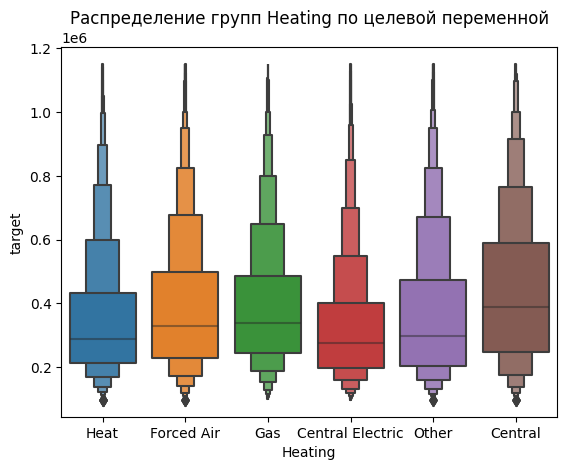

Groups Heat & Forced Air has statisticaly difference (p_value=0.000)
Groups Heat & Gas has statisticaly difference (p_value=0.000)
Groups Heat & Central Electric has statisticaly difference (p_value=0.000)
Groups Heat & Other has statisticaly difference (p_value=0.000)
Groups Heat & Central has statisticaly difference (p_value=0.000)
Groups Forced Air & Gas has statisticaly difference (p_value=0.000)
Groups Forced Air & Central Electric has statisticaly difference (p_value=0.000)
Groups Forced Air & Other has statisticaly difference (p_value=0.000)
Groups Forced Air & Central has statisticaly difference (p_value=0.000)
Groups Gas & Central Electric has statisticaly difference (p_value=0.000)
Groups Gas & Other has statisticaly difference (p_value=0.000)
Groups Gas & Central has statisticaly difference (p_value=0.000)
Groups Central Electric & Other has statisticaly difference (p_value=0.000)
Groups Central Electric & Central has statisticaly difference (p_value=0.000)
Groups Other & Ce

In [486]:
# исследуем признак Heating используя все тот же тест манна-Уитни

sns.boxenplot(df, x='Heating', y='target')
plt.title('Распределение групп Heating по целевой переменной')
plt.show()

# запустим цикл и пройдемся по всем группам для того, чтобы понять есть ли те группы, 
# которые статистически не будут давать разнообразие после чего объединим эти группы
cats = df['Heating'].unique()

for x in range(len(cats)):
    for y in range(len(cats)):
        if y>x and cats[x]!=cats[y]:
            print(u_test(df, 'Heating', 'target', [cats[x], cats[y]]))
            
            
# Groups Heat & Other statisticaly equal (p_value=0.155) заменим Heat на Other
df['Heating'] = df['Heating'].replace({'Heat': 'Other'})


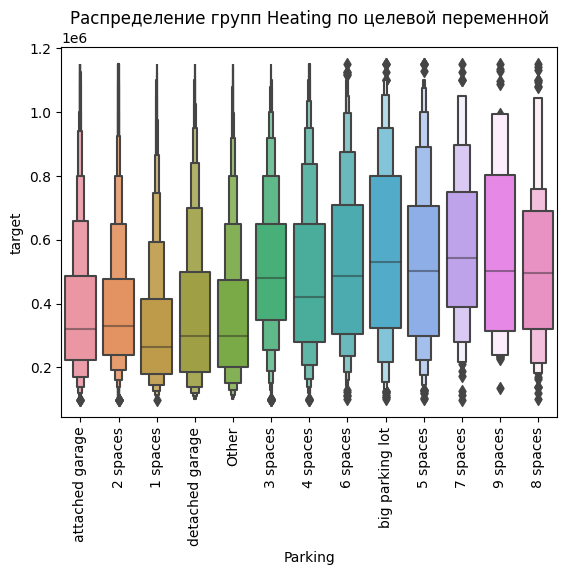

Groups detached garage & Other statisticaly equal (p_value=0.097)
Groups 3 spaces & 6 spaces statisticaly equal (p_value=0.685)
Groups 3 spaces & 5 spaces statisticaly equal (p_value=0.230)
Groups 3 spaces & 9 spaces statisticaly equal (p_value=0.470)
Groups 3 spaces & 8 spaces statisticaly equal (p_value=0.810)
Groups 4 spaces & 9 spaces statisticaly equal (p_value=0.076)
Groups 4 spaces & 8 spaces statisticaly equal (p_value=0.139)
Groups 6 spaces & big parking lot statisticaly equal (p_value=0.133)
Groups 6 spaces & 5 spaces statisticaly equal (p_value=0.687)
Groups 6 spaces & 7 spaces statisticaly equal (p_value=0.064)
Groups 6 spaces & 9 spaces statisticaly equal (p_value=0.523)
Groups 6 spaces & 8 spaces statisticaly equal (p_value=0.650)
Groups big parking lot & 5 spaces statisticaly equal (p_value=0.251)
Groups big parking lot & 7 spaces statisticaly equal (p_value=0.594)
Groups big parking lot & 9 spaces statisticaly equal (p_value=0.991)
Groups big parking lot & 8 spaces stat

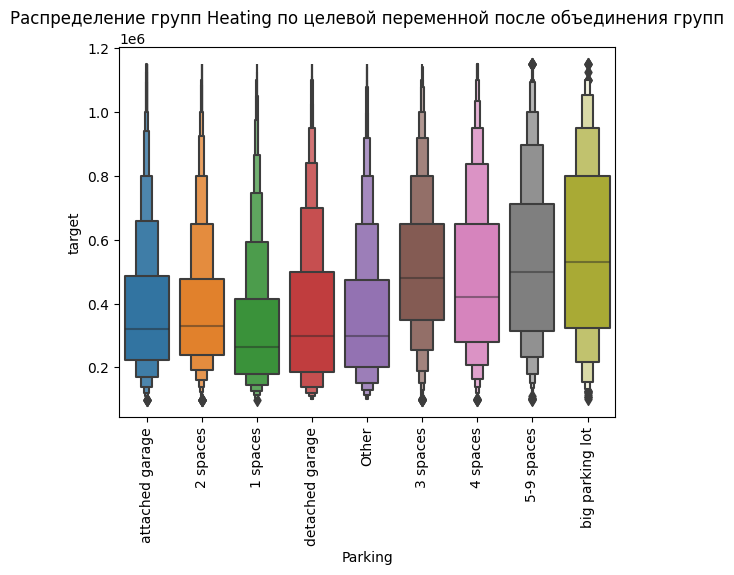

In [487]:
# Исследуем признак Parking

sns.boxenplot(df, x='Parking', y='target')
plt.title('Распределение групп Heating по целевой переменной')
plt.xticks(rotation=90)
plt.show()

cats = df['Parking'].unique()

for x in range(len(cats)):
    for y in range(len(cats)):
        if y>x and cats[x]!=cats[y]:
            test_result = u_test(df, 'Parking', 'target', [cats[x], cats[y]])
            if 'equal' in test_result:
                print(test_result)
                
                
# Объединим группы 5-6-7-8-9 в единую группу

dct_parking_cats = {x: '5-9 spaces' for x in ['5 spaces', '6 spaces', '7 spaces', '8 spaces', '9 spaces']}

df['Parking']  = df['Parking'].apply(lambda x: dct_parking_cats[x] if x in dct_parking_cats.keys() else x)

sns.boxenplot(df, x=df['Parking'].apply(lambda x: dct_parking_cats[x] if x in dct_parking_cats.keys() else x), y='target')
plt.title('Распределение групп Heating по целевой переменной после объединения групп')
plt.xticks(rotation=90)
plt.show()


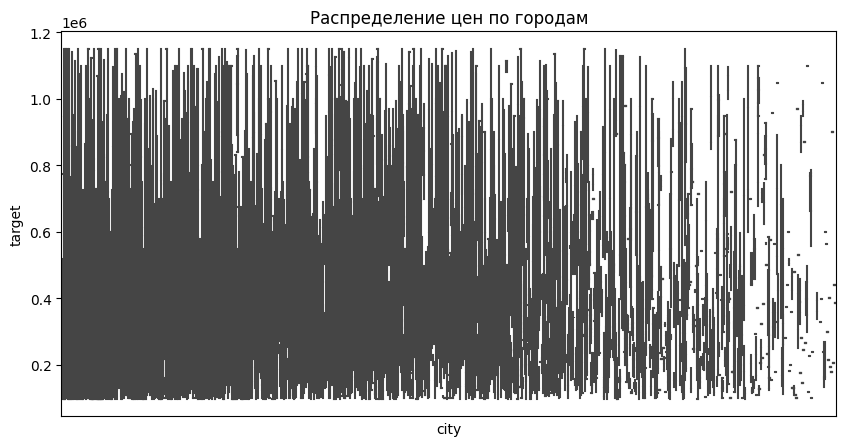

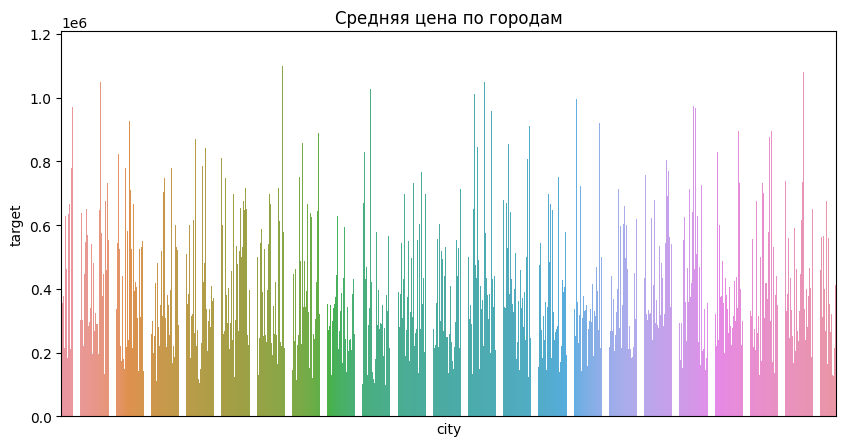

Группы в признаке city имеют статически значимых различий p-value: 0.0


In [488]:
# в данных есть отсутвующие города, удалим такие 
city_hidden_nan = df[(df['city'] == ' ') | (df['city'] == '--')]
df = df.drop(city_hidden_nan.index, axis=0)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='city', y='target', showfliers=False)
plt.xticks([])
plt.title('Распределение цен по городам')
plt.show()


plt.figure(figsize=(10, 5))
sns.barplot(df.groupby('city')['target'].mean().reset_index(), x='city', y='target')
plt.title('Средняя цена по городам')
plt.xticks([])
plt.show()

# Посмотрим на признак city с точки зрения статистики

groups = [df[df['city'] == city]['target'] for city in df['city'].unique()]
_, p_value = kruskal(*groups)

if p_value >= 0.05:
    print(f"Группы в признаке city не имеют статически значимых различий p-value: {round(p_value, 4)}")
else: print(f"Группы в признаке city имеют статически значимых различий p-value: {round(p_value, 4)}")

# признак полезный, поэтому будем использовать его в модели

In [489]:
# сохраним очищенные данные в отдельный файл
df.to_csv('data/data_cleaned.csv', index=False)

На этом завершаем EDA и предварительный фича инжеринг и подведем итоги на данном этапе удалось
- Проверить зависимость между данными и целевой переменной
- Провести дополнительную очистку данных
- Посмотреть на распределение признаков, найти дополнительные выбросы и устранить
- Сделать фича-инжениринг и объеденить группы в некоторых признаках по статистическим тестам
- сократить размерность признака zip_area, укрупнив географию

### <center> **4. Feature Engineering - Создание и преобразование признаков** </center>

In [7]:
# сделаем импорт данных 

df = pd.read_csv(r'data/data_cleaned.csv', low_memory=False)

In [8]:
# делим выборку на трейн и тест
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [5]:
# признаки city и zipcode_area закодируем label_encoding, остальные категориальные признаки 
# кодируем через One-Hot-Encoding
print(X.select_dtypes(include='O').describe().loc['unique'].sort_values(ascending=False))

zipcode         4077
city            1528
zipcode_area     362
state             34
Parking            9
propertyType       6
Heating            5
status             3
Cooling            2
Name: unique, dtype: object


In [119]:
# разобъем признаки по группам для кодирования
one_hot_cols = ['propertyType', 'status', 'state', 'Heating', 'Cooling', 'Parking']
ordinal_encod_cols = ['city', 'zipcode_area', 'zipcode']
standart_scaling_cols = X.select_dtypes(exclude='O').columns

# подготовим тренсформер для разных признаков признаков
preprocessor = ColumnTransformer([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_encod_cols),
    ('scaler', StandardScaler(), standart_scaling_cols)]
)

# произведем отбор признаков, чтобы уменьшить размерность
k_best_predictors = SelectKBest(mutual_info_regression, k=30)

pipeline = Pipeline(
    [('preprocessing', preprocessor)]
)

# трансформируем признаки
X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_test_transformed = pipeline.transform(X_test)

### <center> 5. Построение Моделей </center>

In [9]:
def mae(y_true, y_pred):
    error = round(mean_absolute_error(y_true, y_pred), 0)
    return f"Значение абсолютной ошибки MAE -> {error}", error

def rmse(y_true, y_pred):
    error = round(mean_squared_error(y_true, y_pred, squared=False), 0)
    return f"Значение RMSE -> {error}", error

In [26]:
# Линейная модель плохо апроксимирует в данной задаче, величины ошибок весьма большие

linreg_model = LinearRegression()

linreg_model.fit(X_train_transformed, np.log(y_train))

y_pred = linreg_model.predict(X_test_transformed)


print(mae(y_test, np.exp(y_pred))[0])
print(rmse(y_test, np.exp(y_pred))[0])

Значение абсолютной ошибки MAE -> 112456.0
Значение RMSE -> 167185.0


In [ ]:
# попытки оптимизировать гиперпараметры через стандартный градиентный бустинг не дали хороших результатов
# т.к. на моей машине данный алгоритм работает очень медленно

def optuna_gb_optimizer(trial, X, y, cv=5):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth',  3, 7, step=1),
        'random_state': 42,
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, step=1),
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile']),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10, step=1)
    }
    
    regressor = GradientBoostingRegressor(**params)
    
    score = cross_val_score(
        estimator=regressor,
        X=X,
        y=y,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    return -np.mean(score)


# study = optuna.create_study(study_name='gb_mape', direction='minimize')
# study.optimize(partial(optuna_gb_optimizer, X=X_train_transformed, y=y_train), n_trials=15)

In [10]:
# пробуем обучить и сразу подобрать гиперпараметры для алгоритма Catboost


# список фичей получен на отдельном шаге построения модели catboost который не включен в проект
best_features = ['sqft', 'zipcode_area', 'zipcode', 'Year built', 'propertyType',
       'state', 'Remodeled year', 'city', 'baths', 'school_ratings_average']

X_train_consize = X_train[best_features]


cat_features = list(X_train_consize.select_dtypes(include='O').columns)

train_pool = Pool(X_train_consize, np.log(y_train), cat_features=cat_features)

def optuna_catboost_optimizer(trial, pool):
    
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('max_depth',  3, 10, step=1),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10, step=1),
        'rsm': trial.suggest_loguniform('rsm', 0.1, 0.9),
        'loss_function': 'RMSE',
        'early_stopping_rounds': 50,
        'random_seed': 42,
        'verbose': False
    }
       
    df_cv = cv(params=params,
        pool=pool,
        fold_count=5,
        logging_level='Silent'
    )
    

    return df_cv.iloc[-10:]['test-RMSE-mean'].mean() # выбирает последние 10 итераций и берем среднию по метрике rsme


study = optuna.create_study(study_name='catboost', direction='minimize')
study.optimize(partial(optuna_catboost_optimizer, pool=train_pool), n_trials=20)

[I 2025-04-09 20:10:09,883] A new study created in memory with name: catboost
[I 2025-04-09 20:10:41,406] Trial 0 finished with value: 0.9420709169496423 and parameters: {'iterations': 170, 'learning_rate': 0.01626200683380128, 'max_depth': 8, 'l2_leaf_reg': 6, 'min_data_in_leaf': 6, 'rsm': 0.6880012404787206}. Best is trial 0 with value: 0.9420709169496423.
[I 2025-04-09 20:11:35,387] Trial 1 finished with value: 0.2778697437078798 and parameters: {'iterations': 220, 'learning_rate': 0.03775052821467235, 'max_depth': 10, 'l2_leaf_reg': 4, 'min_data_in_leaf': 4, 'rsm': 0.15785187353531832}. Best is trial 1 with value: 0.2778697437078798.
[I 2025-04-09 20:11:44,592] Trial 2 finished with value: 0.8314332919829864 and parameters: {'iterations': 60, 'learning_rate': 0.04997841268381198, 'max_depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 10, 'rsm': 0.3542282811500412}. Best is trial 1 with value: 0.2778697437078798.
[I 2025-04-09 20:13:14,908] Trial 3 finished with value: 0.356591676304

In [11]:
# судя по графику оптимизации, каких то существенных изменение показателей качества не происходило за все 20 эпох
optuna.visualization.plot_optimization_history(study)

In [13]:
# выведим лучшие парметры
study.best_params

{'iterations': 500,
 'learning_rate': 0.29361279411004637,
 'max_depth': 10,
 'l2_leaf_reg': 10,
 'min_data_in_leaf': 8,
 'rsm': 0.4836766527039818}

In [12]:
# обучаем лучшую модель которую подобрали через алгоритм optuna

model = CatBoostRegressor(**study.best_params, verbose=False)

model.fit(train_pool)

y_train_pred = model.predict(X_train[best_features])

y_test_pred = model.predict(X_test[best_features])

# выводим метрики по выборкам train и test
print("TRAIN", mae(y_train, np.exp(y_train_pred))[0])
print("TRAIN", rmse(y_train, np.exp(y_train_pred))[0])

print("TEST", mae(y_test, np.exp(y_test_pred))[0])
print("TEST", rmse(y_test, np.exp(y_test_pred))[0])

TRAIN Значение абсолютной ошибки MAE -> 55325.0
TRAIN Значение RMSE -> 87303.0
TEST Значение абсолютной ошибки MAE -> 60742.0
TEST Значение RMSE -> 95872.0


In [58]:
print("Средняя цена недвижимости по тестовой выборке", round(y_test.mean(), 0))

Средняя цена недвижимости по тестовой выборке 383375.0


##### Промежуточный вывод по алгоритму Catboost
В среднем модель catboost дает неплохие предсказания так при средней цене в тестовой выборке `383K$` значение `MAE 61K$`
Это около `16% по метрике MAPE`, с учетом изначально сильно грязных данных с большим количеством пустот, результат получился хороший.

In [152]:
# Обучаем еще один популярный алгоритм XGBoost, и сравниваем метрики с Catboost, чтобы выбрать лучший алгоритм для продакшен

dtrain = xgb.DMatrix(X_train_transformed, np.log(y_train))
dtest = xgb.DMatrix(X_test_transformed, np.log(y_test))

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 7,
    'eval_metric': 'mae',
    'reg_lambda': 2,   
    'reg_alpha': 1.2,  
    'subsample': 0.8,  
    'colsample_bytree': 0.9,  
    'random_state': 42
}

xgb_regressor = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=600,
    early_stopping_rounds=50,
    evals=[(dtest, "Test")],
)

log_pred_train = xgb_regressor.predict(dtrain)
log_pred_test = xgb_regressor.predict(dtest)

[0]	Test-mae:0.43363
[1]	Test-mae:0.41276
[2]	Test-mae:0.39425
[3]	Test-mae:0.37967
[4]	Test-mae:0.36433
[5]	Test-mae:0.35175
[6]	Test-mae:0.33997
[7]	Test-mae:0.33039
[8]	Test-mae:0.32297
[9]	Test-mae:0.31402
[10]	Test-mae:0.30623
[11]	Test-mae:0.30017
[12]	Test-mae:0.29447
[13]	Test-mae:0.28838
[14]	Test-mae:0.28328
[15]	Test-mae:0.27929
[16]	Test-mae:0.27478
[17]	Test-mae:0.27104
[18]	Test-mae:0.26793
[19]	Test-mae:0.26514
[20]	Test-mae:0.26203
[21]	Test-mae:0.25957
[22]	Test-mae:0.25649
[23]	Test-mae:0.25418
[24]	Test-mae:0.25191
[25]	Test-mae:0.24973
[26]	Test-mae:0.24822
[27]	Test-mae:0.24633
[28]	Test-mae:0.24466
[29]	Test-mae:0.24291
[30]	Test-mae:0.24128
[31]	Test-mae:0.23999
[32]	Test-mae:0.23845
[33]	Test-mae:0.23738
[34]	Test-mae:0.23656
[35]	Test-mae:0.23499
[36]	Test-mae:0.23369
[37]	Test-mae:0.23233
[38]	Test-mae:0.23115
[39]	Test-mae:0.23014
[40]	Test-mae:0.22903
[41]	Test-mae:0.22800
[42]	Test-mae:0.22728
[43]	Test-mae:0.22644
[44]	Test-mae:0.22564
[45]	Test-mae:0.2247

In [ ]:
# выводим метрики для XGBoost
print("TRAIN", mae(y_train, np.exp(log_pred_train))[0])
print("TRAIN", rmse(y_train, np.exp(log_pred_train))[0])

print("TEST", mae(y_test, np.exp(log_pred_test))[0])
print("TEST", rmse(y_test, np.exp(log_pred_test))[0])

TRAIN Значение абсолютной ошибки MAE -> 53228.0
TRAIN Значение RMSE -> 83671.0
TEST Значение абсолютной ошибки MAE -> 61229.0
TEST Значение RMSE -> 96409.0


##### Промежуточный вывод по алгоритму XGBoost

Наблюдается картина очень похожих значений с catboost, однако между значениями метрик на TRAIN и TEST 
получились большие значения, что может свидетельствовать о переобучении модели

In [ ]:
# сериализуем модель и сохраняем ее в папке с приложением

with open('app\model\model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
# сохраним тестовые данные, которые будем передавать потом в модель для предсказания 
test_data = X_test[best_features].copy()
test_data['target'] = y_test

test_data.to_csv('app/data/test_df.csv')

### <center> **Финальный вывод по проекту** </center>

В ходе проекта, удалось реализовать изначально поставленную задачу, а именно — разработать модель, которая позволила бы обойти конкурентов по скорости и качеству совершения сделок.

---

Перед нами ставилась задача классической регрессии, предсказывать будем стоимость недвижимости. 
В результате которой получилось построить подходящую регрессионную модель машинного обучения на основе алгоритма **Catboost** с показателями метрик `mae -> 61k` и `rmse 96k`, про при средней цене недвижимости в `383k` показывает
весьма неплохие показатели качества так `MAPE` получается около 16%.

---

В ходе реализации проекта, были представленные очень неструктурированные, зашумленные данные с большим количеством пропусков, но выходе удалось нетолько структурировать данные, но также выбрать наиболее подходящие признаки, которые затем будут использоваться в inference при построении приложения.
